### Read a waveform and plot

  * Zet dit notebook in "<base_dir>/FineStructure/
  * Select the right filename with waveform data and presto!
  * -m osc


In [ ]:
n = 500000

In [ ]:
import sys
sys.path.insert(0,'python/')
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy
import scipy.optimize as spopt
import scipy.integrate as spint
import scipy.stats as sps
import pandas as pd

from scipy.stats import norm
from tqdm import trange
from scipy.signal import find_peaks

# import data handling claZss
from DT5550_Waveform import *

Analog Voltage
MEGA RUN
Timestamp vinden van hits misschien als dat er is?

In [ ]:
# specify your filename that contains teh waveform data
filename = 'C:/Users/localadmin/Documents/FineStructure/daq/ReadoutClient/lasthugedata.data'
# filename = 'C:/Users/localadmin/Documents/FineStructure/daq/ReadoutClient/higher_voltage_setup.data'
# open the waveform datafile
io = DT5550_Waveform(file=filename)

DT5550_Waveform:: Initialize......
DT5550_Waveform:: Open data file: C:/Users/localadmin/Documents/FineStructure/daq/ReadoutClient/lasthugedata.data


In [ ]:
io = DT5550_Waveform(file=filename)
bovenste_detector = []
onderste_detector = []
for i in trange(n):
    io.read_event()
    idet = 0
    somatie1 = sum(io.analog[idet][:-2][:200])
    baseline1 = somatie1 / 200
    nieuwe_data1 = io.analog[idet][:-2] - baseline1
    idet = 1
    somatie2 = sum(io.analog[idet][:-2][:200])
    baseline2 = somatie2 / 200
    nieuwe_data2 = io.analog[idet][:-2] - baseline2
    onderste_detector.append(nieuwe_data1)
    bovenste_detector.append(nieuwe_data2)

DT5550_Waveform:: Initialize......
DT5550_Waveform:: Open data file: C:/Users/localadmin/Documents/FineStructure/daq/ReadoutClient/lasthugedata.data


100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [4:32:32<00:00, 30.58it/s]


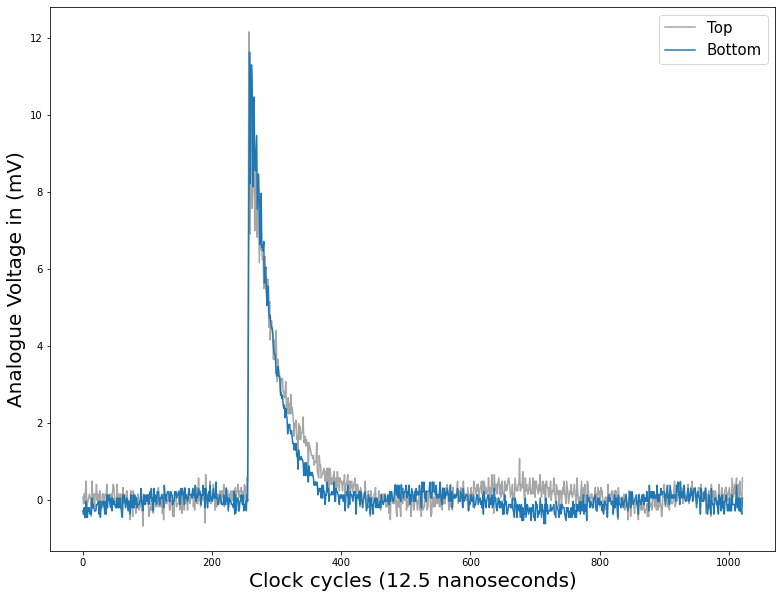

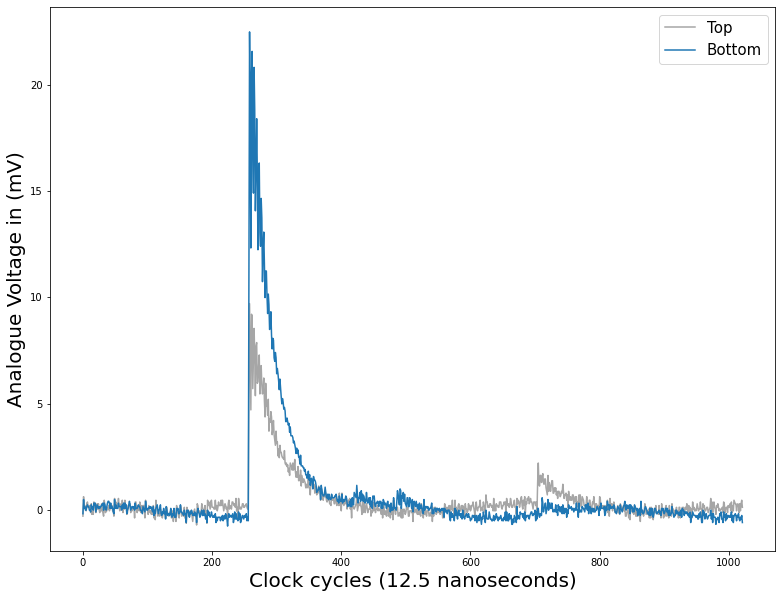

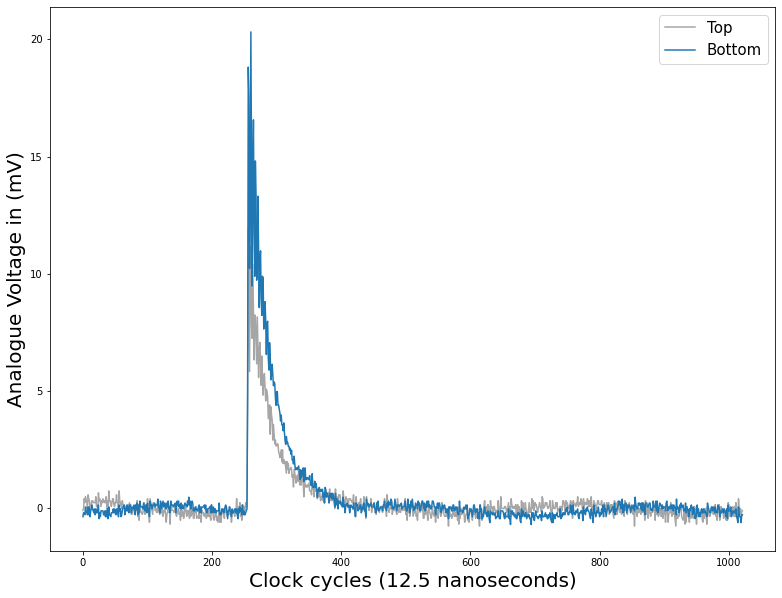

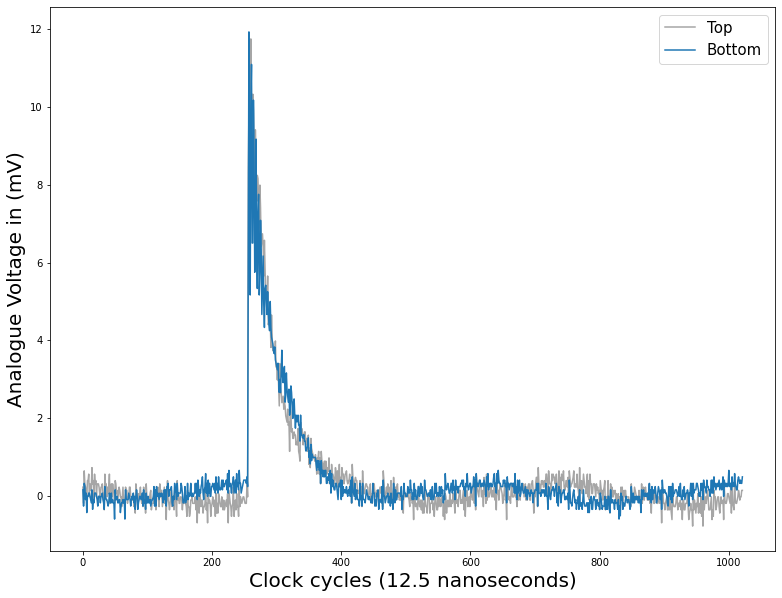

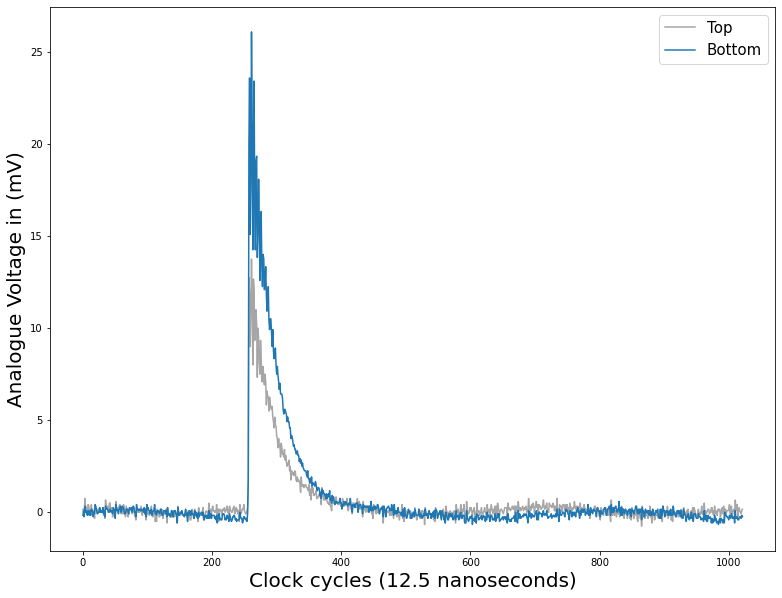

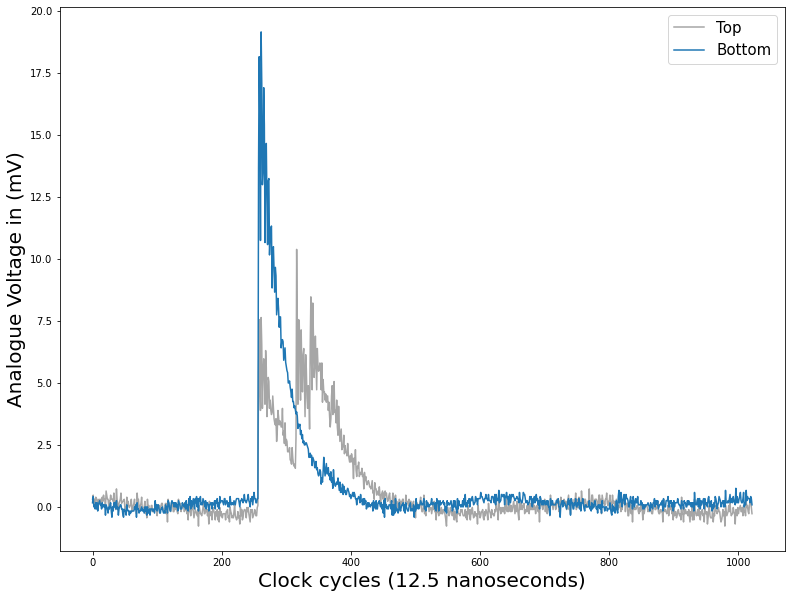

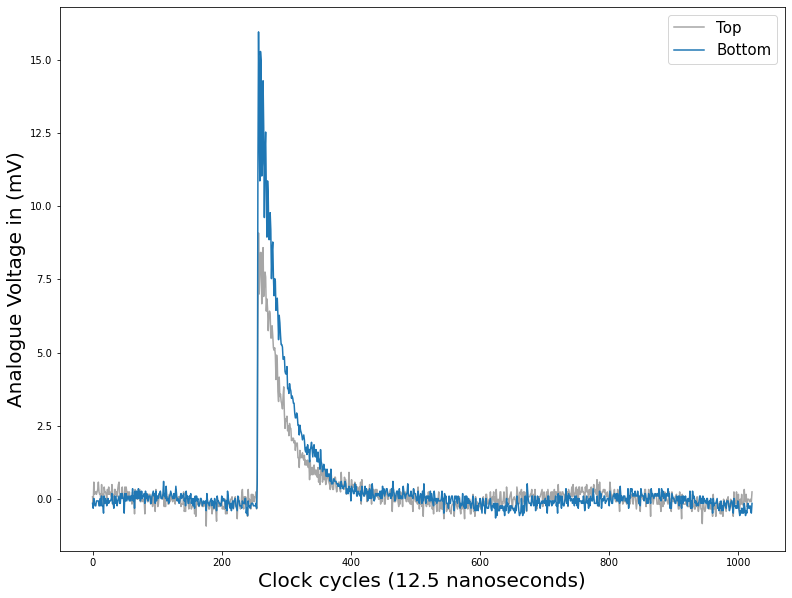

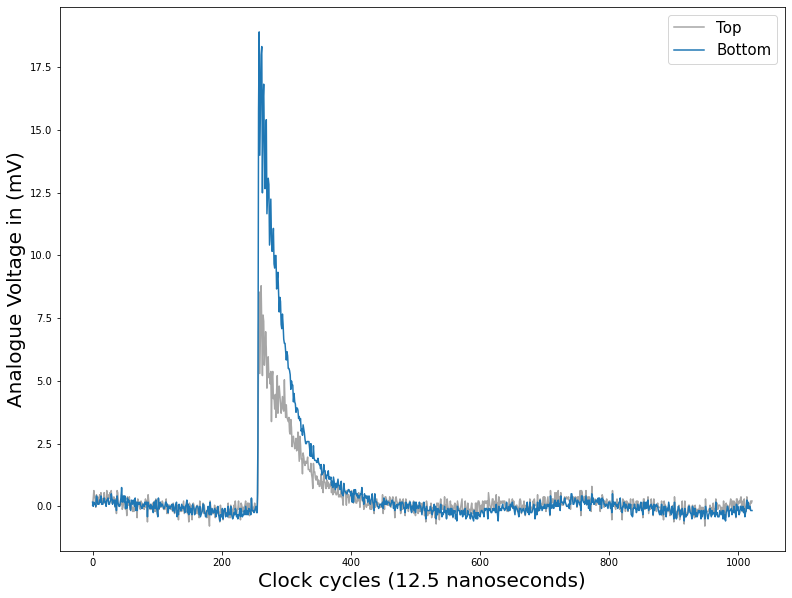

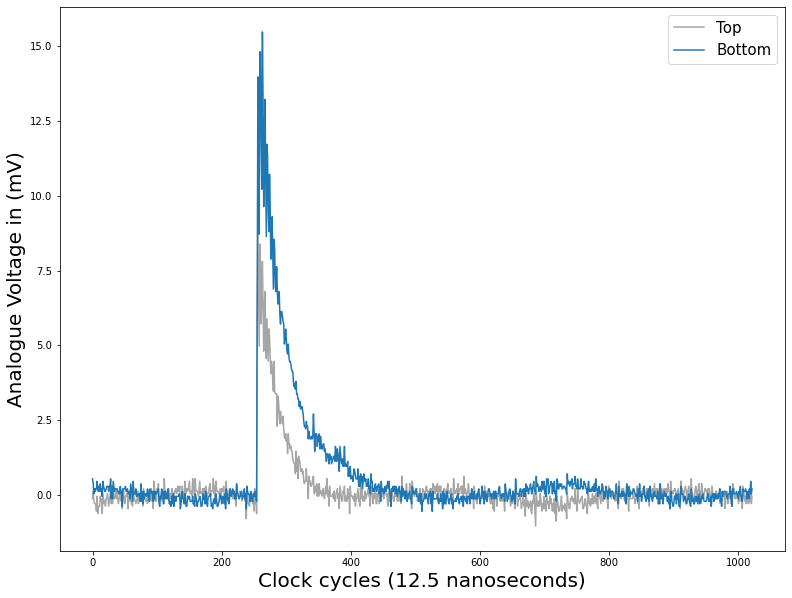

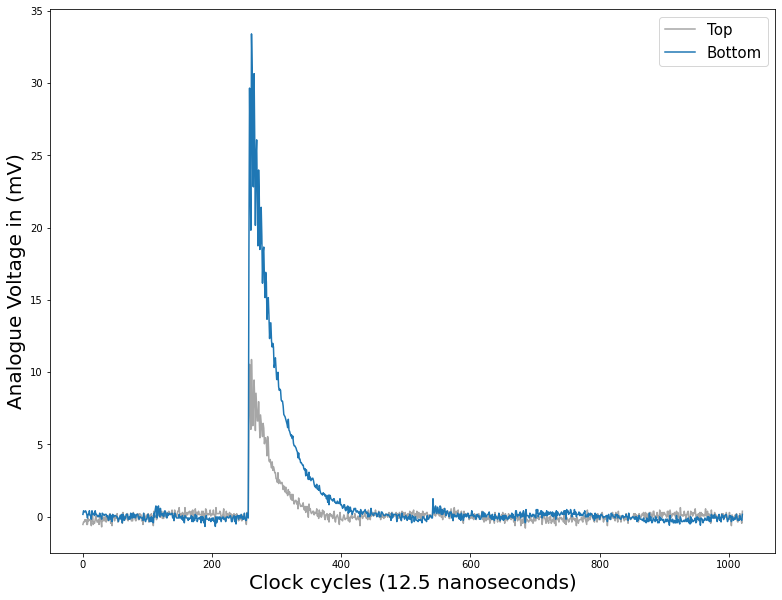

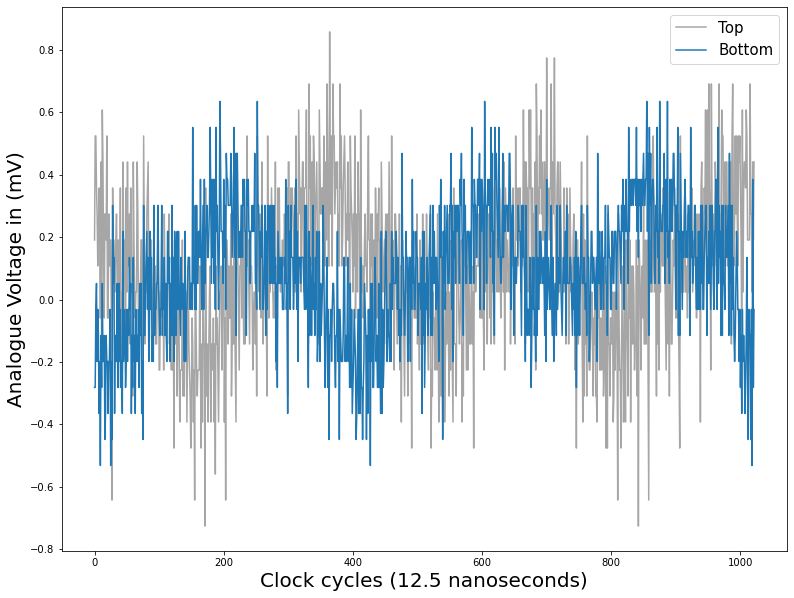

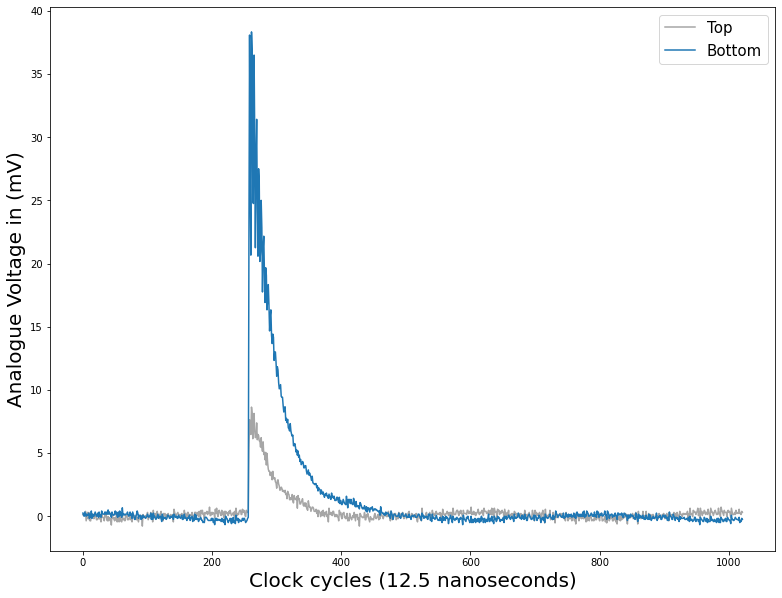

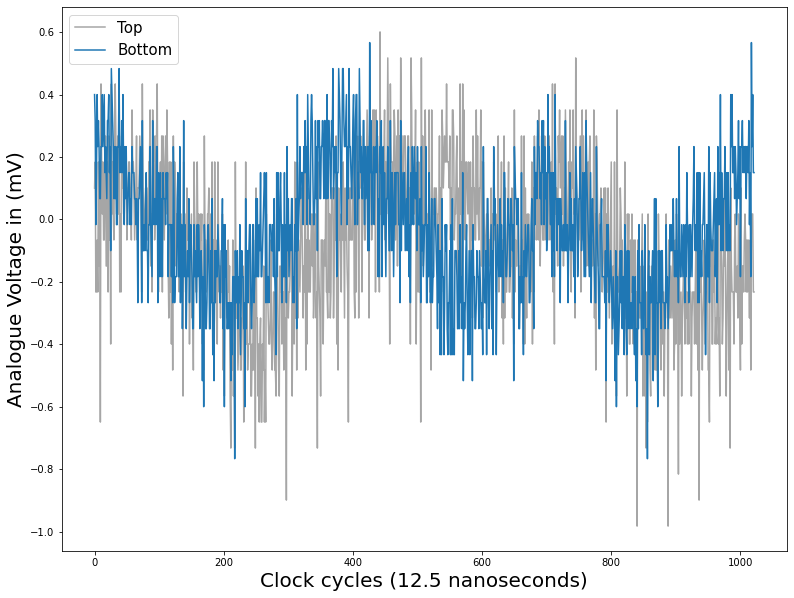

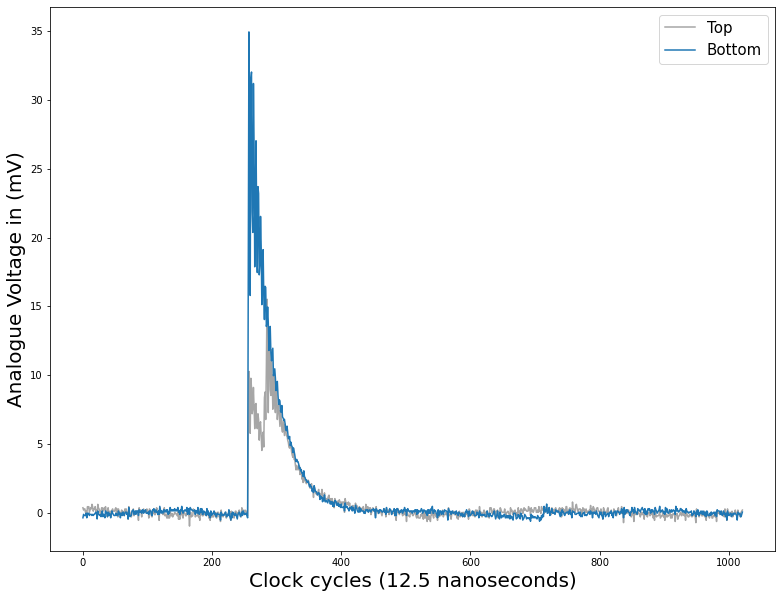

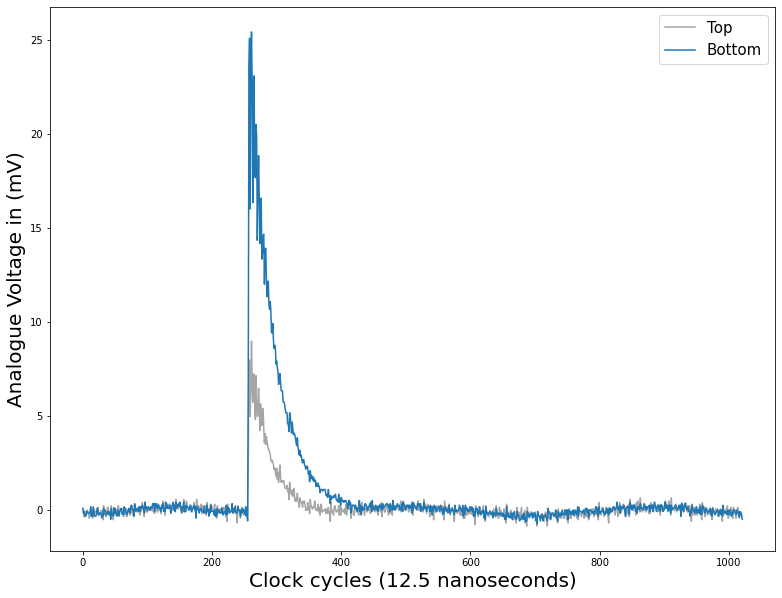

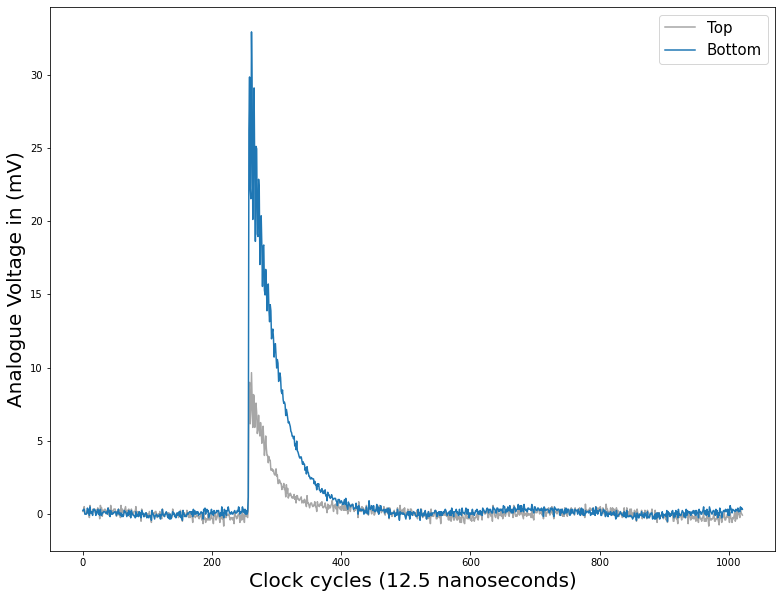

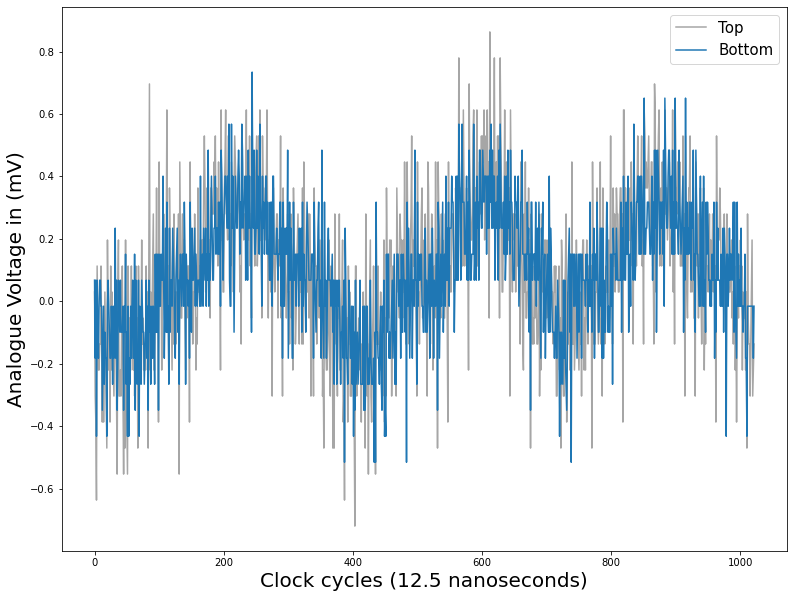

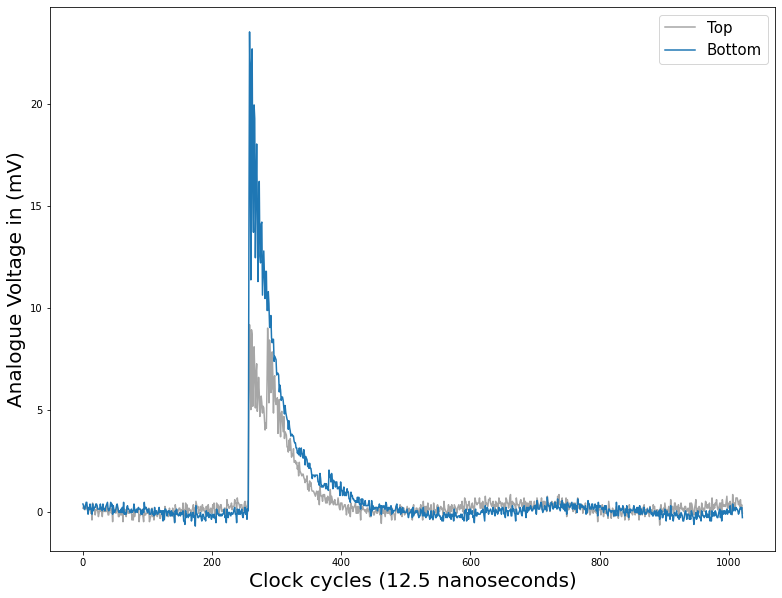

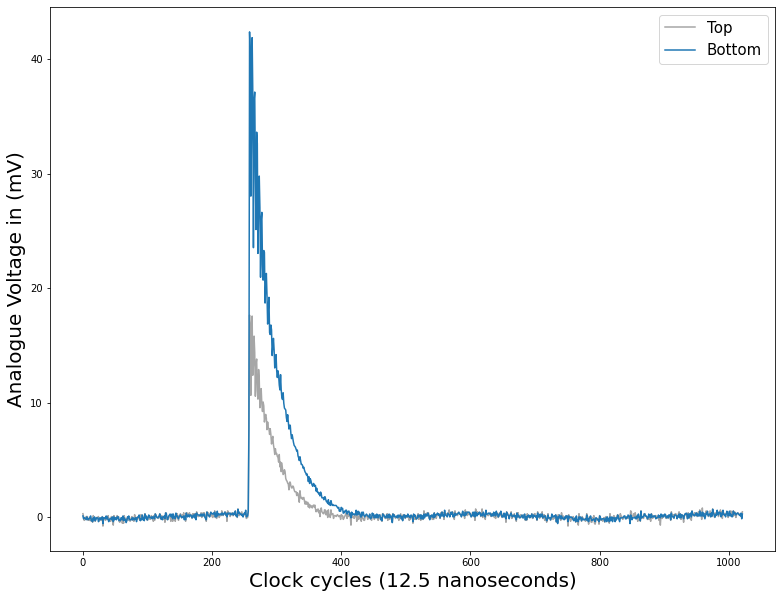

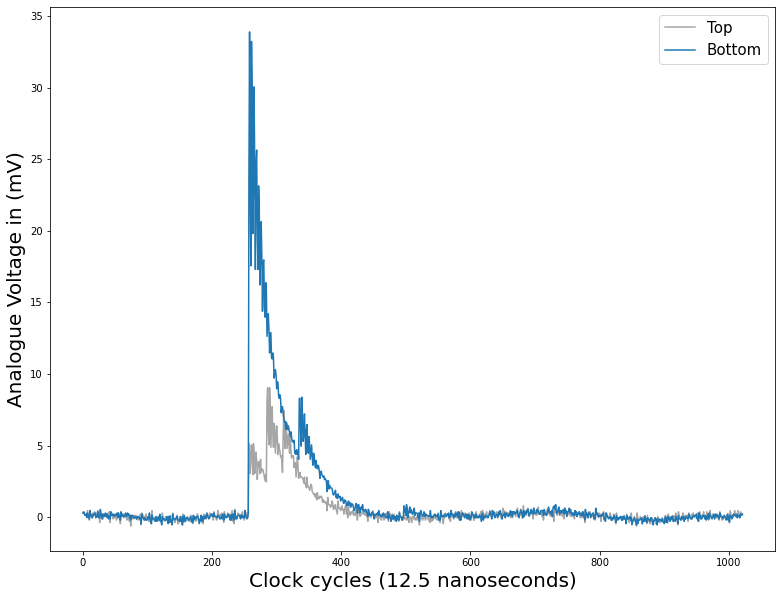

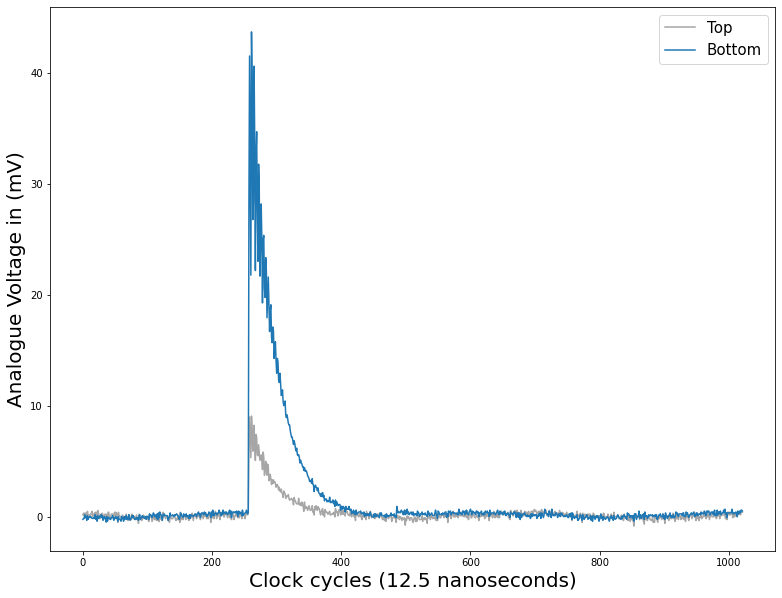

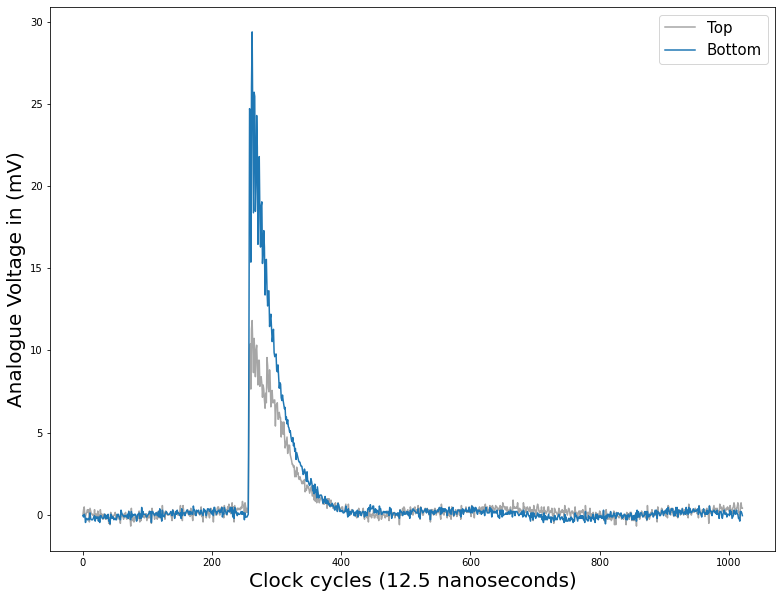

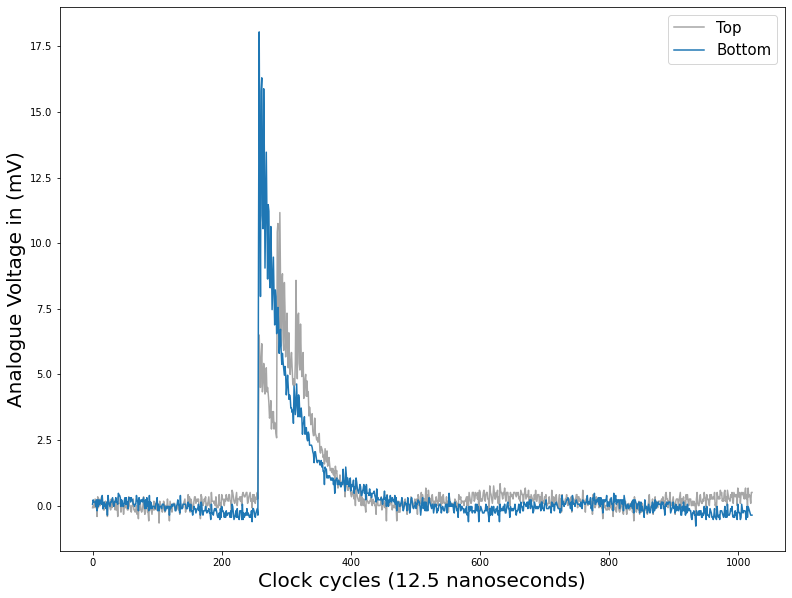

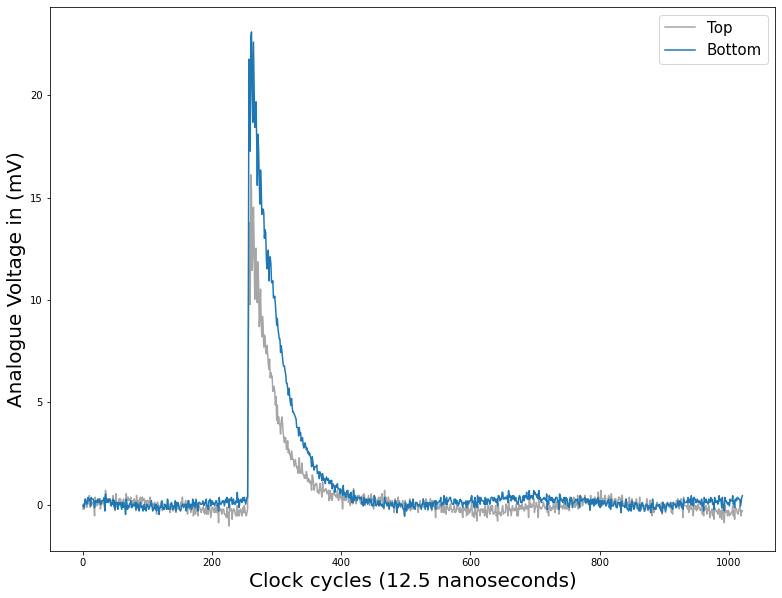

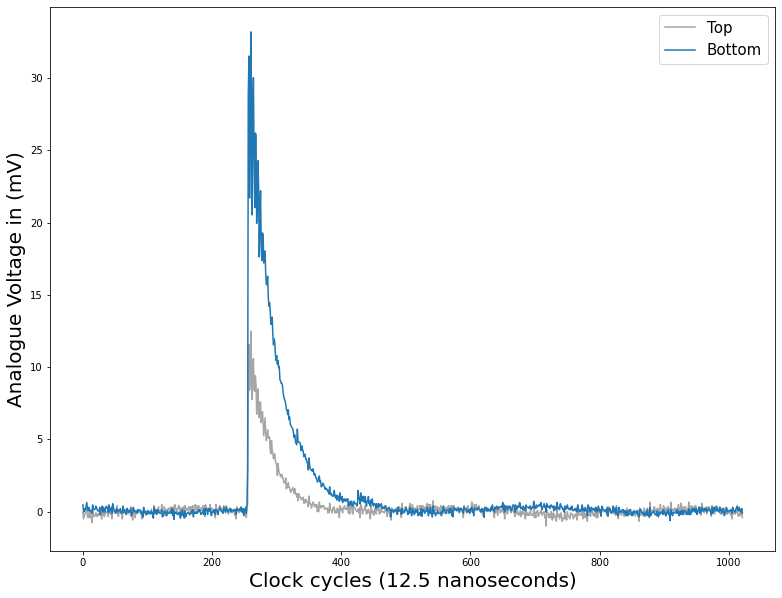

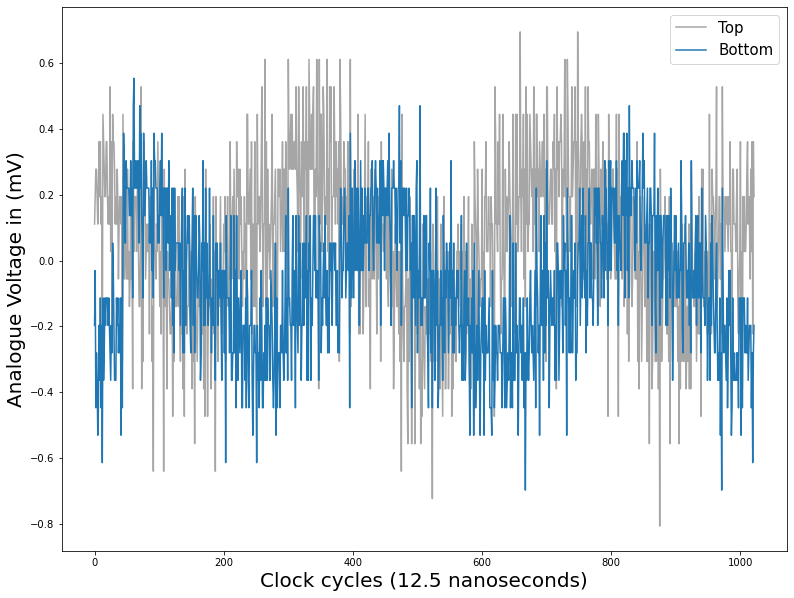

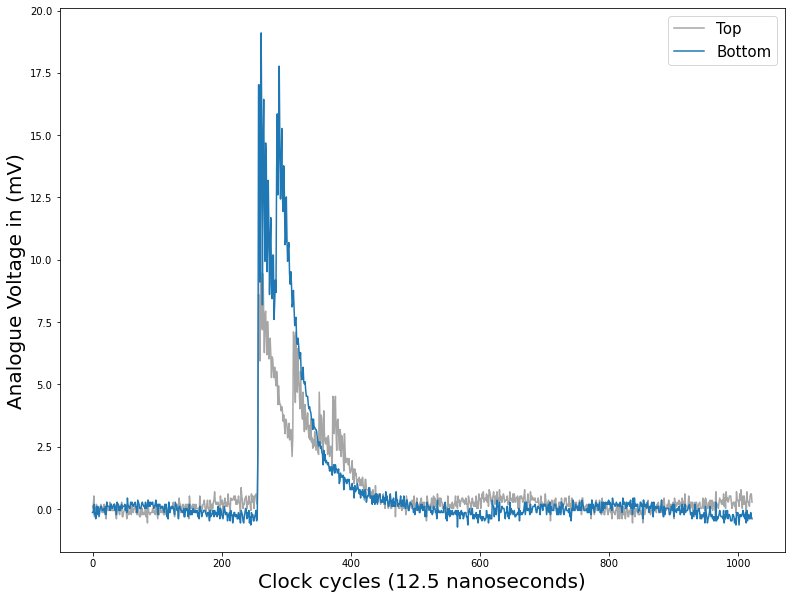

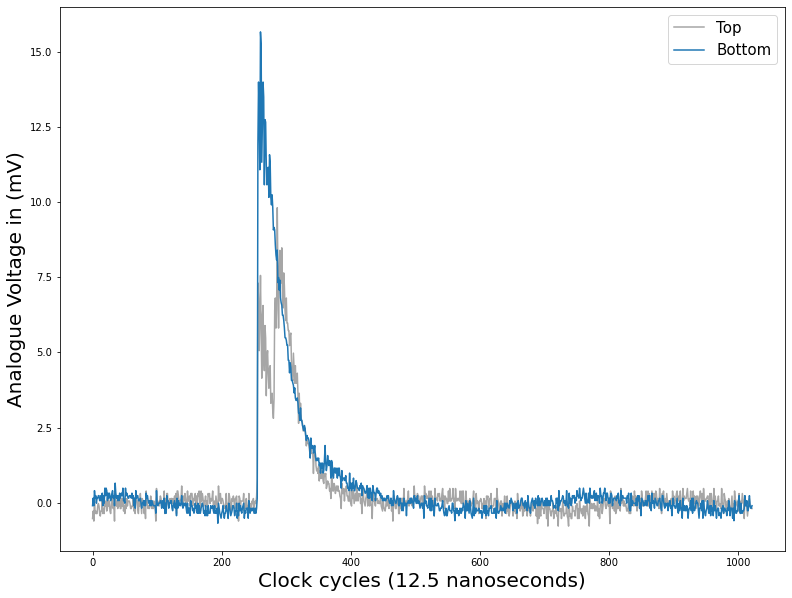

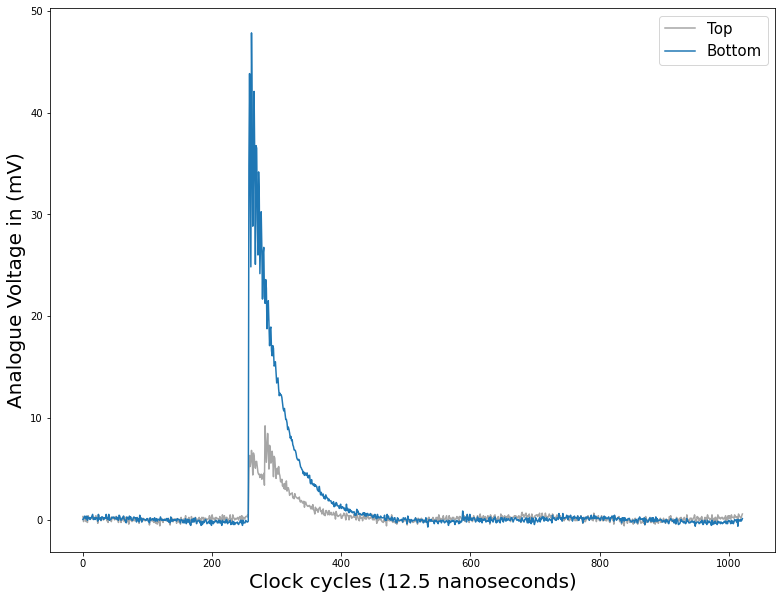

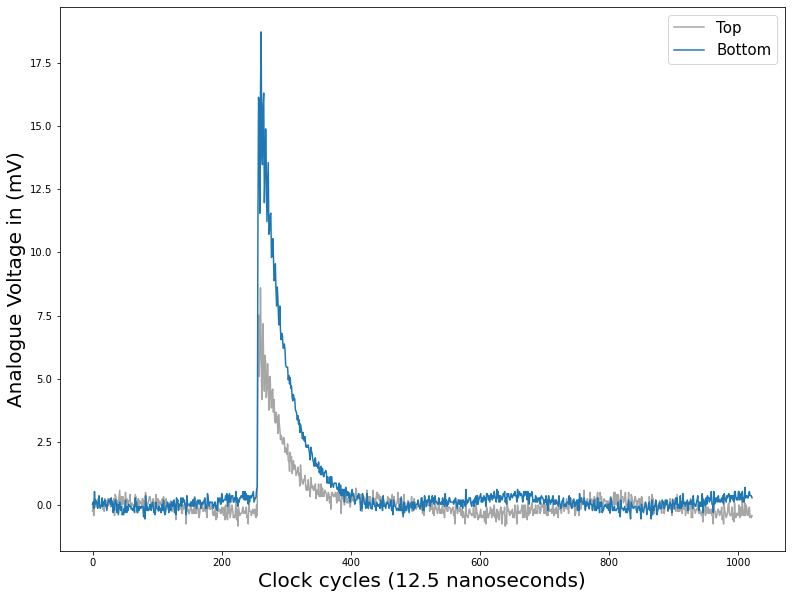

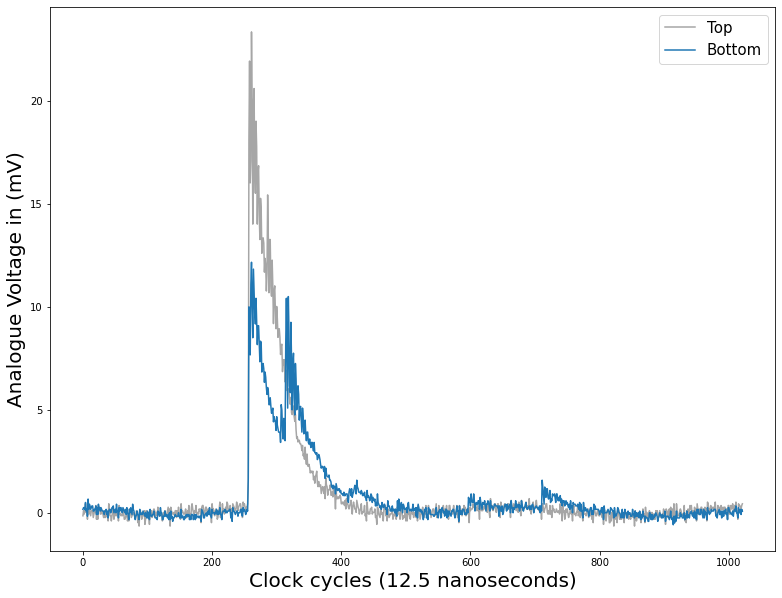

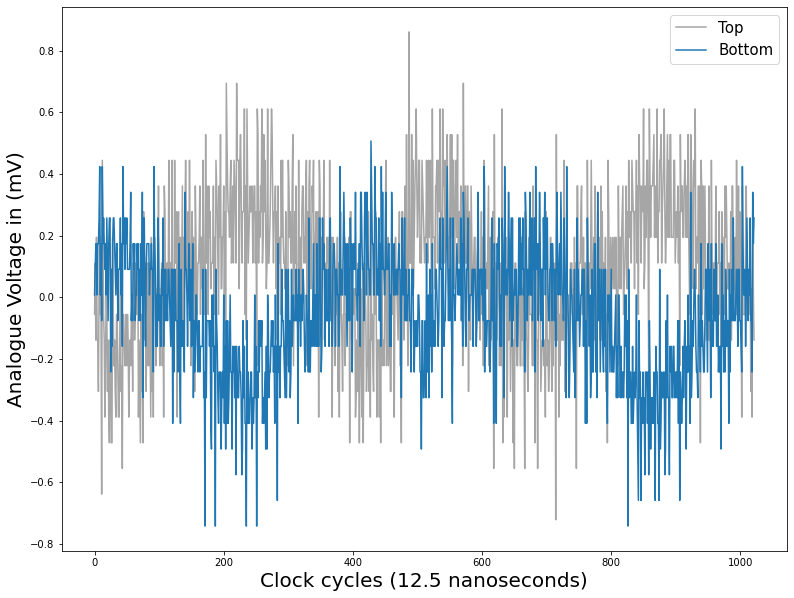

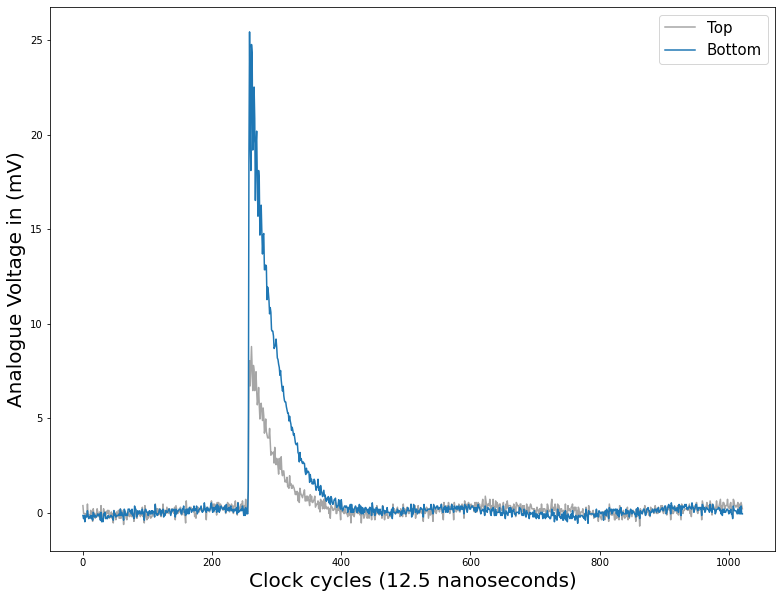

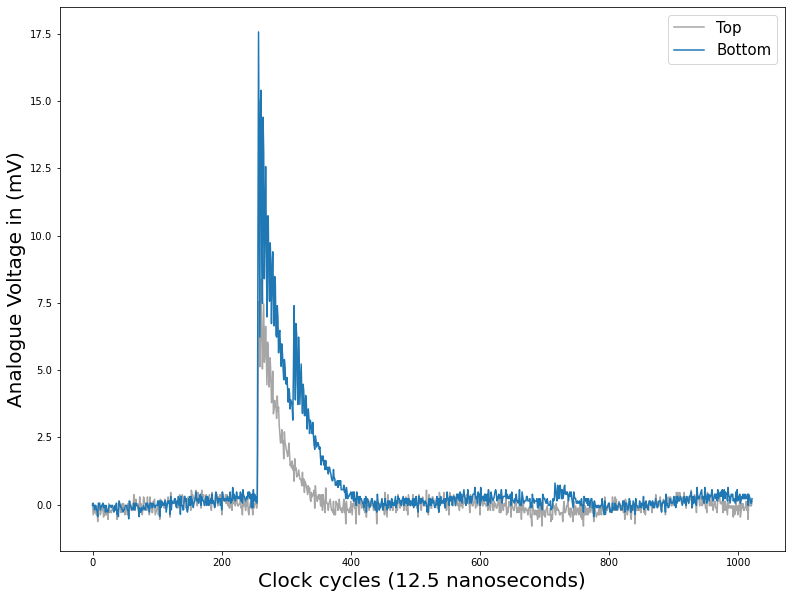

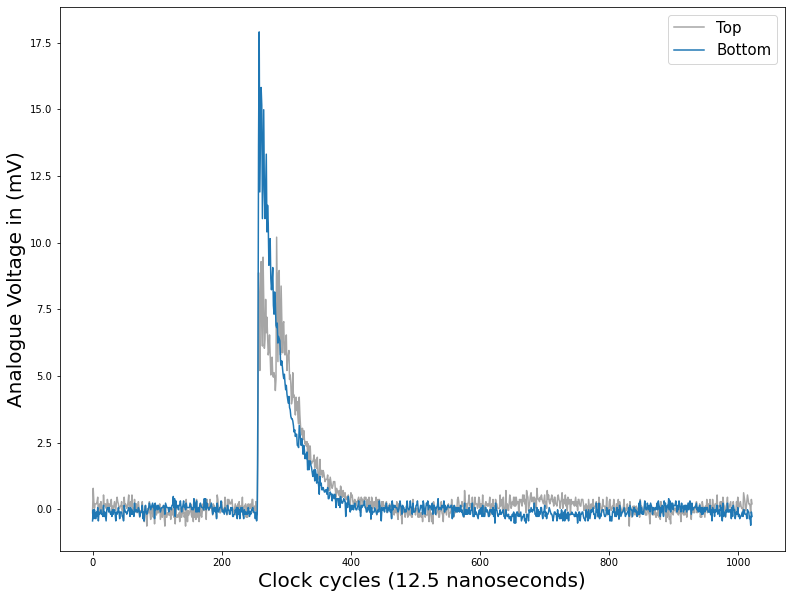

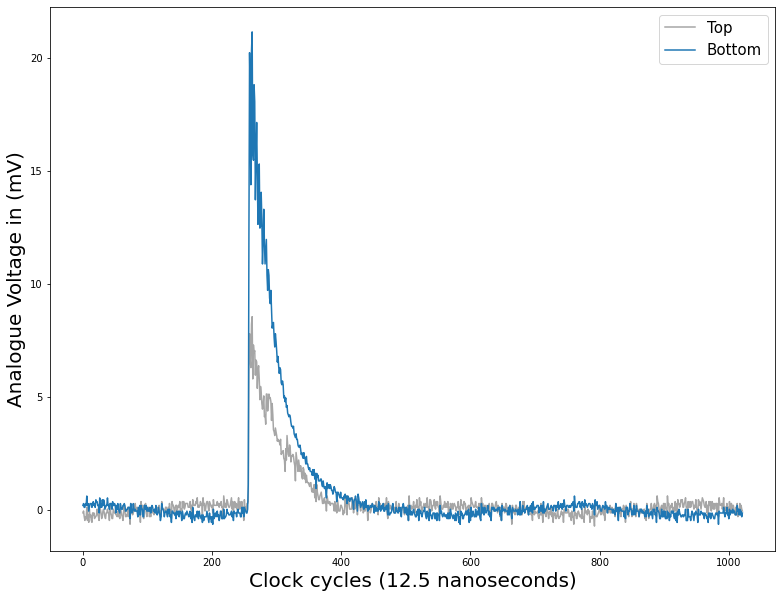

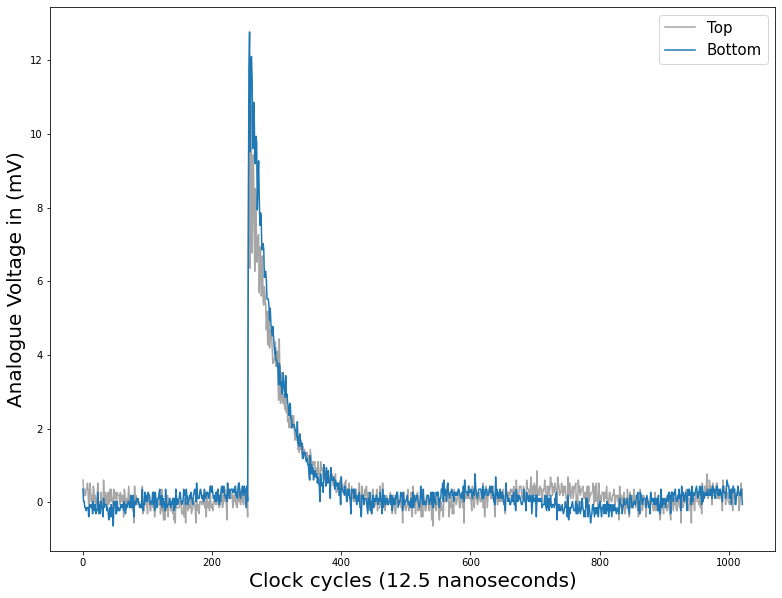

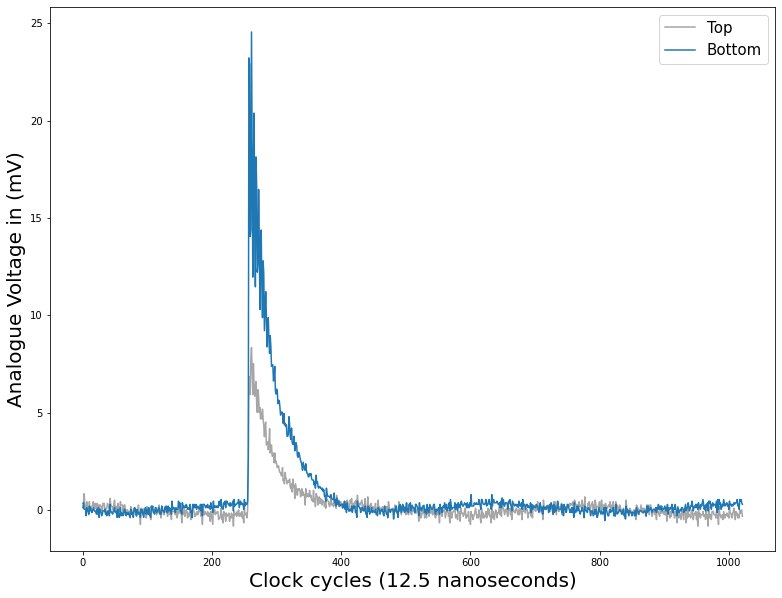

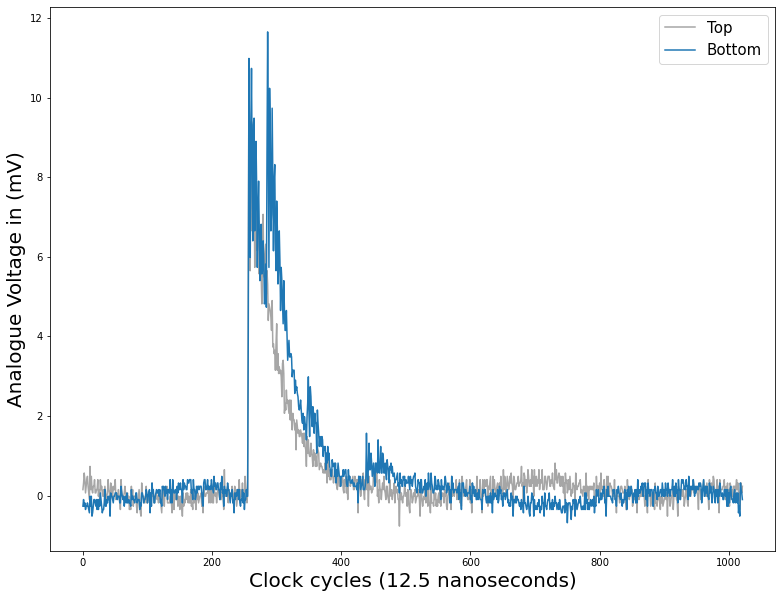

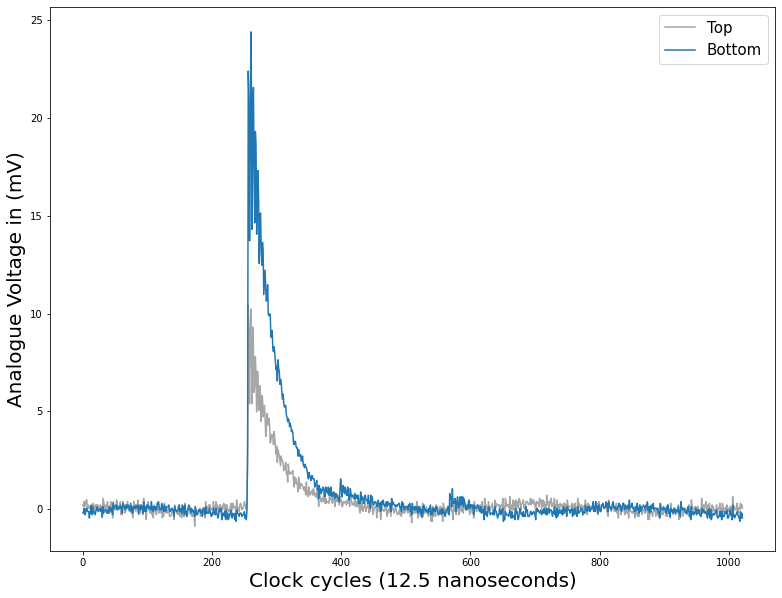

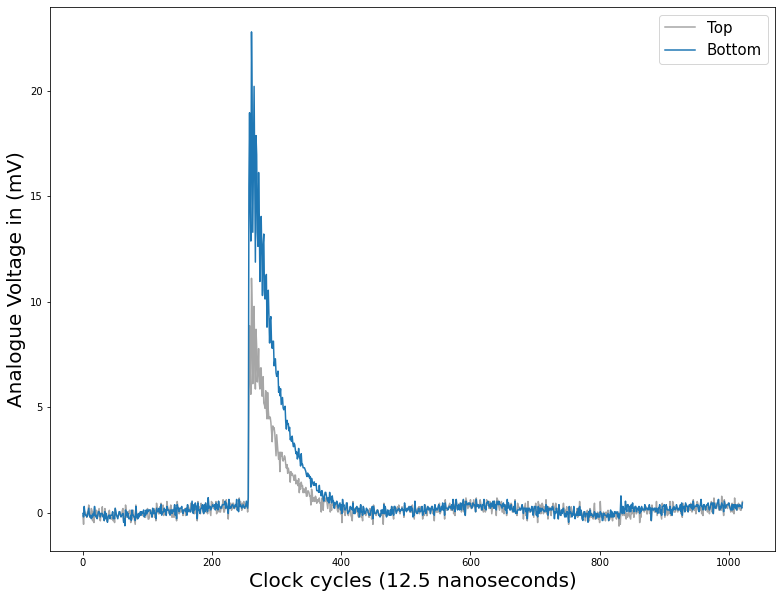

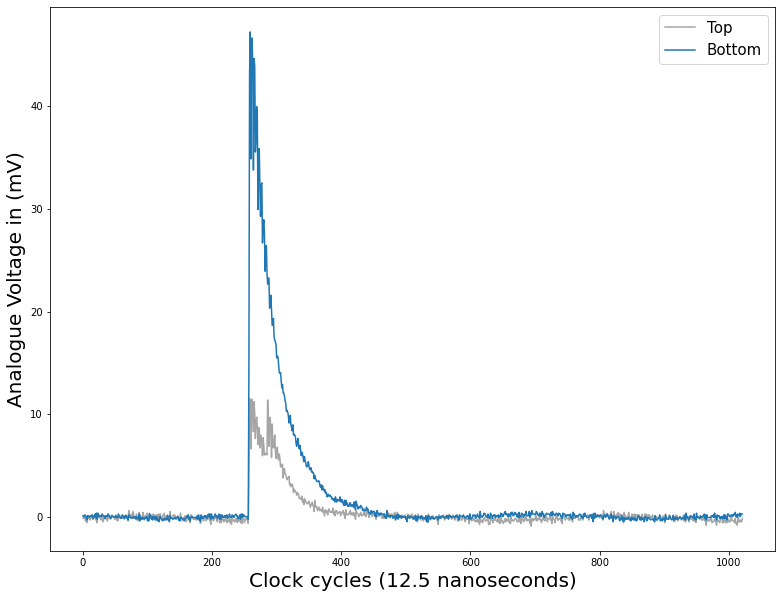

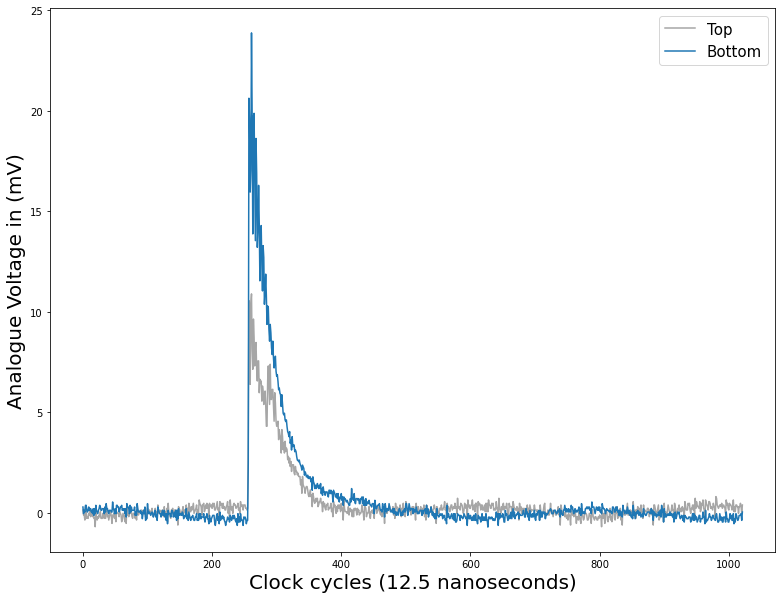

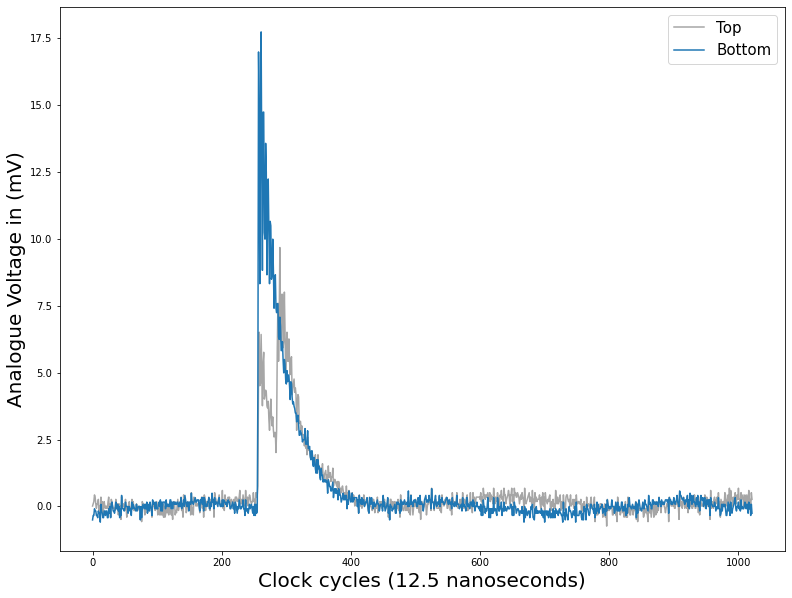

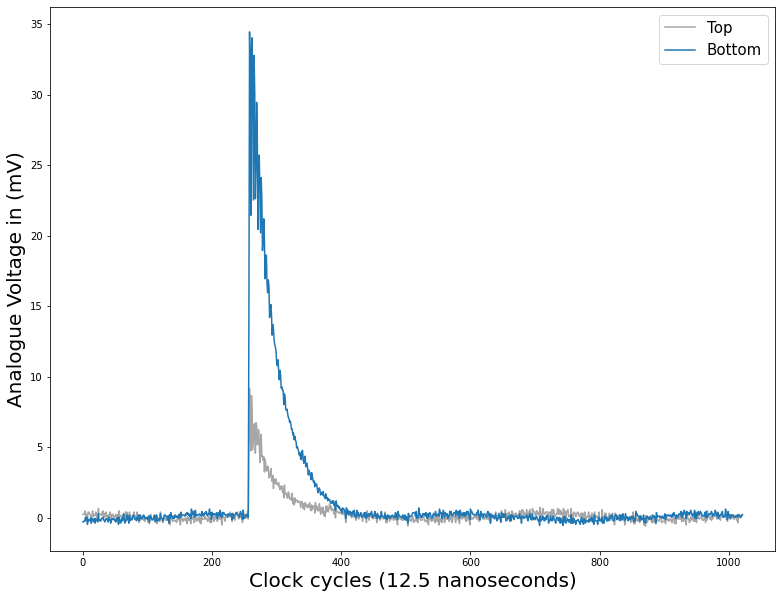

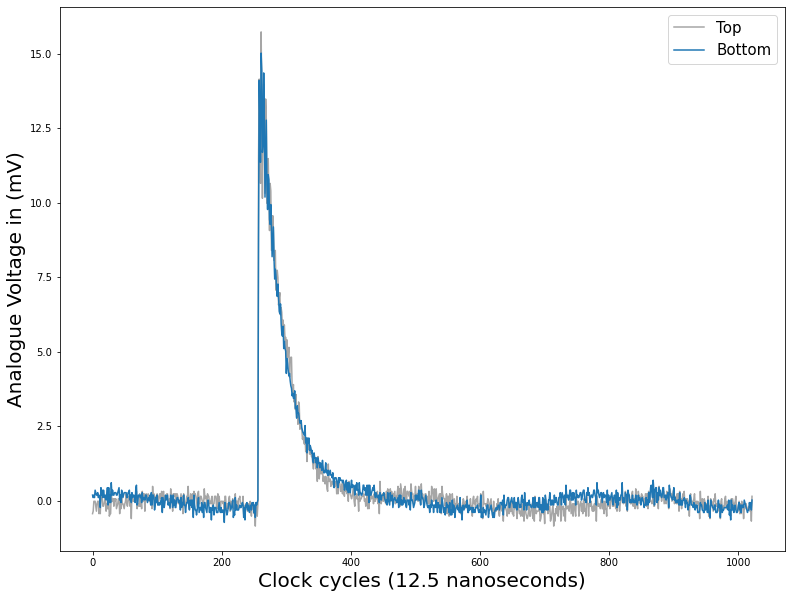

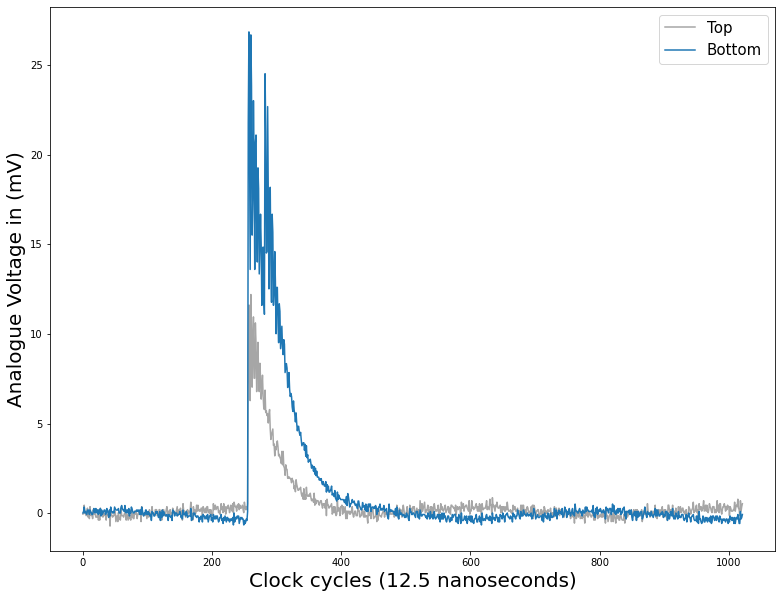

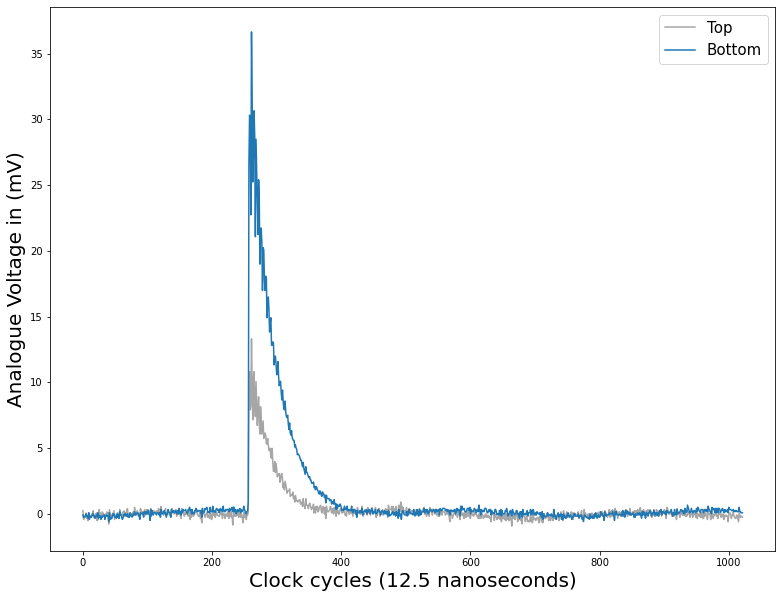

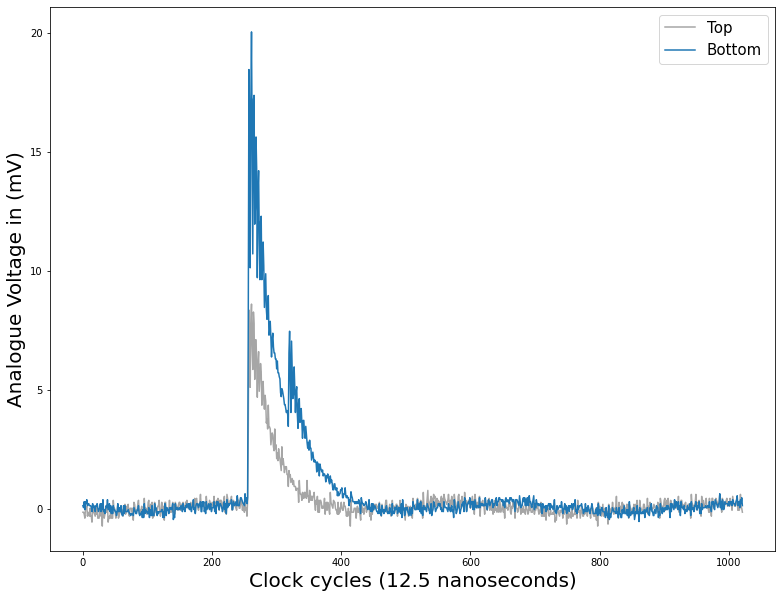

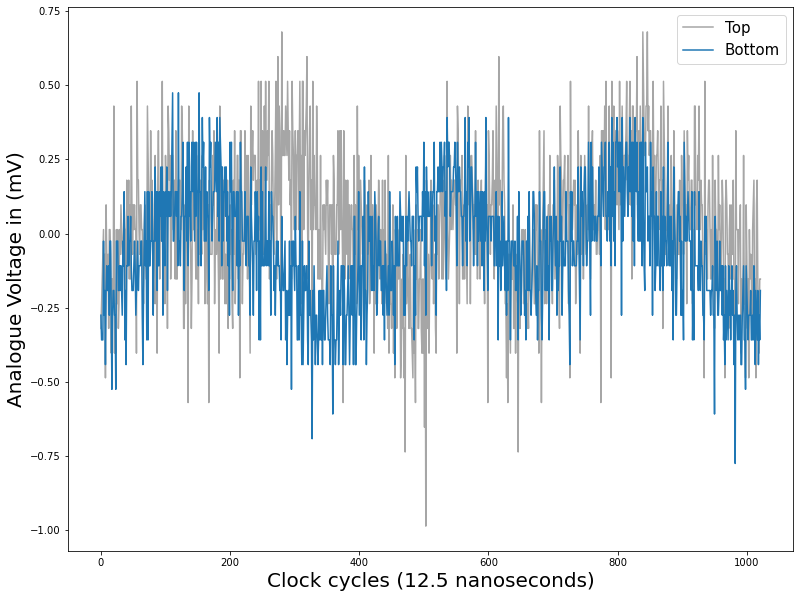

In [ ]:
for i in range(50):
    plt.figure(figsize = (13,10))
    plt.plot(bovenste_detector[i]/12, label = 'Top', alpha = 0.7, color = 'gray')
    plt.plot(onderste_detector[i]/12, label = 'Bottom')
    plt.xlabel("Clock cycles (12.5 nanoseconds)", fontsize = 20)
    plt.ylabel("Analogue Voltage in (mV)", fontsize = 20)
    plt.legend(prop={'size':15})
    plt.show()

In [ ]:
bov_cutoff_list = []
ond_cutoff_list = []

for i in trange(n):
    #cut all events before 250 clockseconds
    if max(bovenste_detector[i]) > 50 and max(onderste_detector[i]) > 50:
        #each max hit should lie around 250ns, as we believe that is what the firmware does
        if max(bovenste_detector[i][:300]) > 40 and max(onderste_detector[i][:300]) > 40:
#                 bov_cutoff_list.append(np.array(bovenste_detector[i])/max(bovenste_detector[i]))
#                 ond_cutoff_list.append(np.array(onderste_detector[i])/max(onderste_detector[i]))
            bov_cutoff_list.append(np.array(bovenste_detector[i]))
            ond_cutoff_list.append(np.array(onderste_detector[i]))
        
counter = len(bov_cutoff_list)

print(counter)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [01:35<00:00, 5253.32it/s]


364111


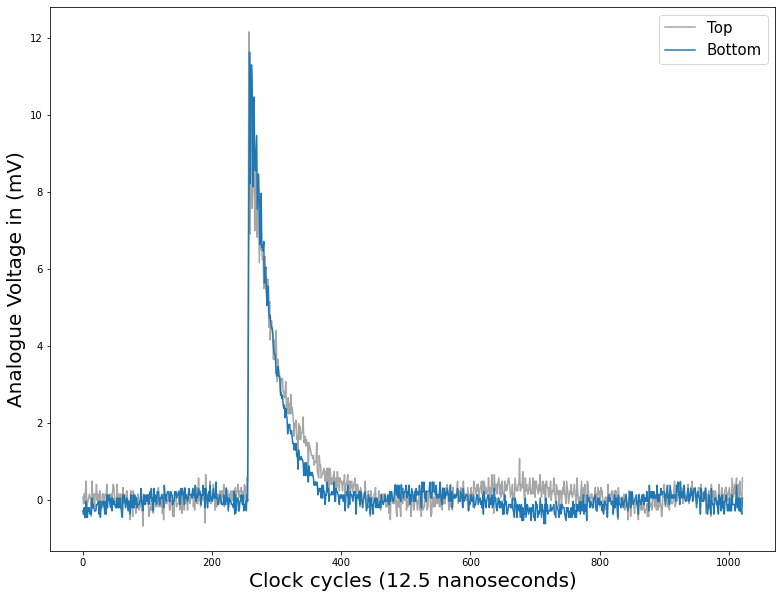

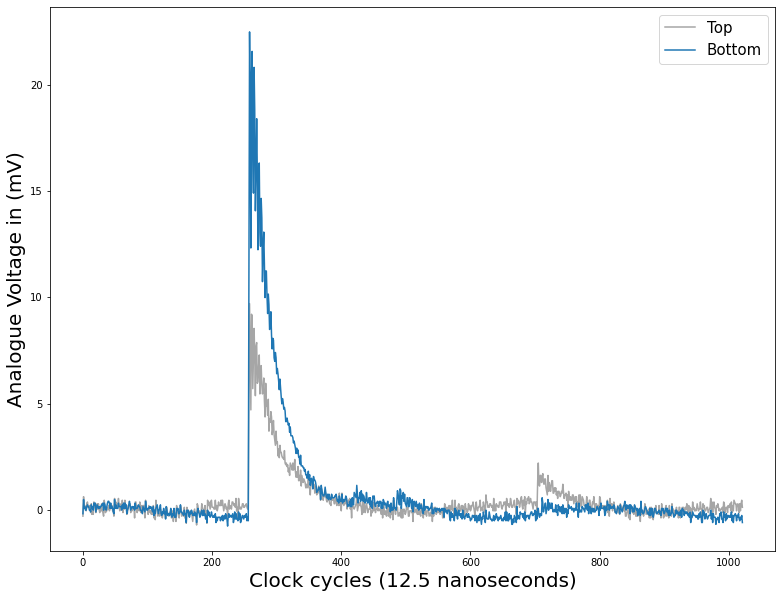

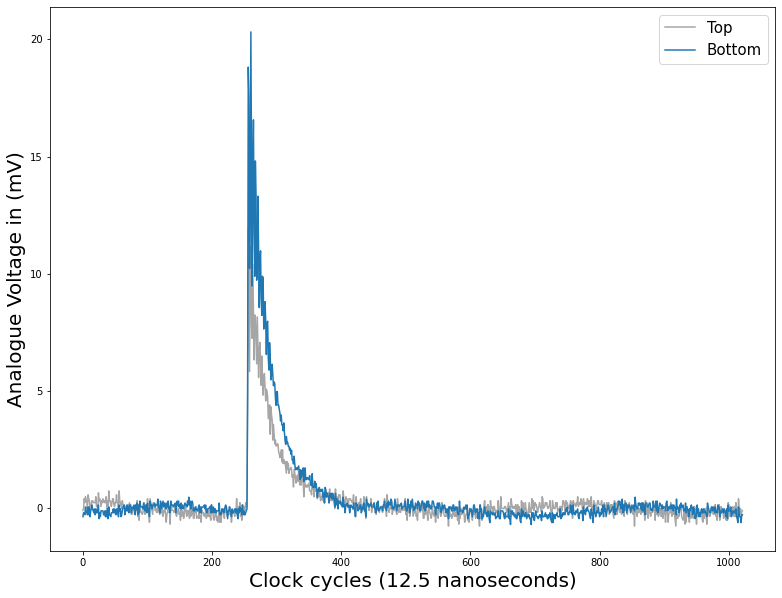

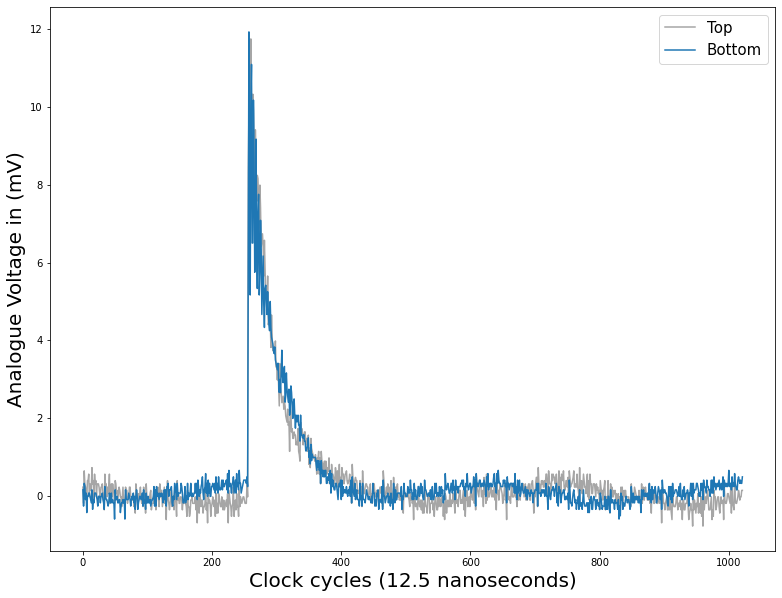

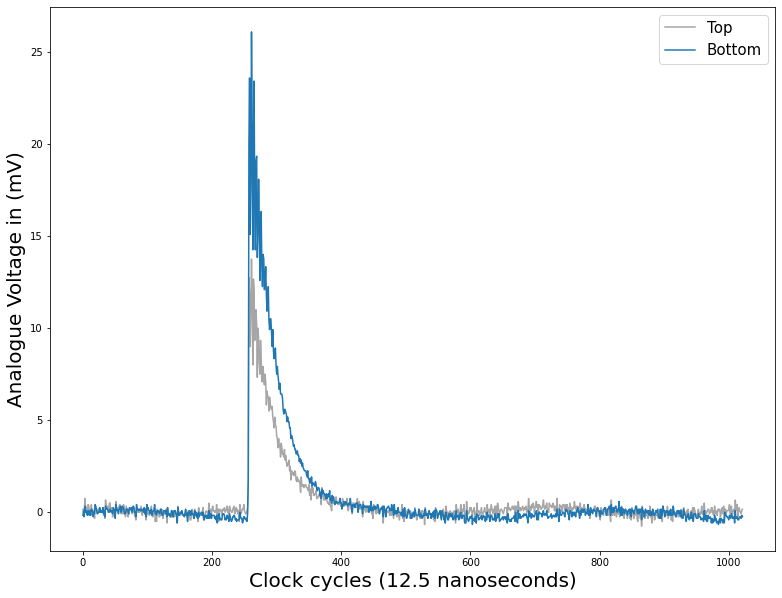

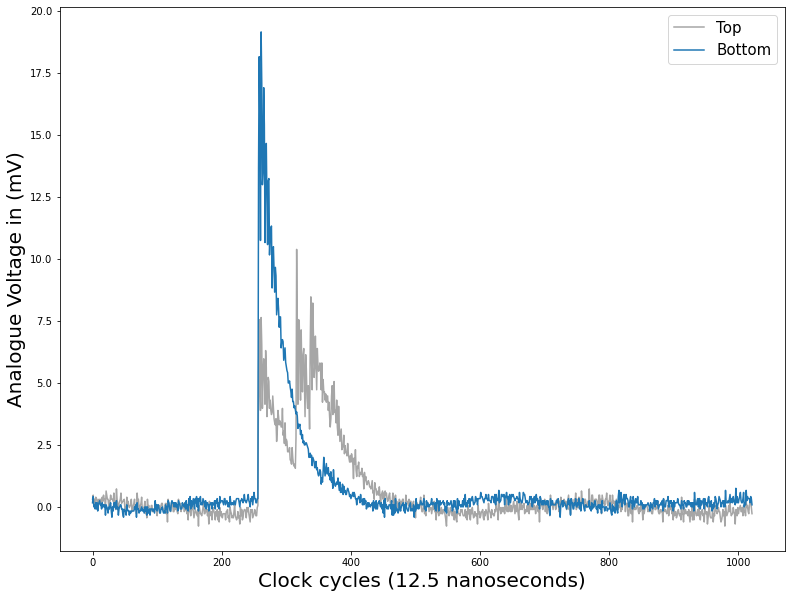

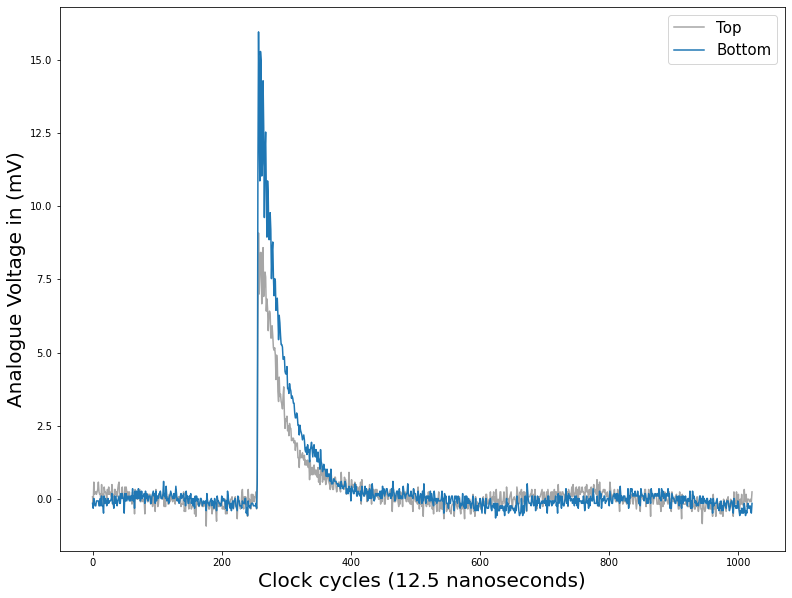

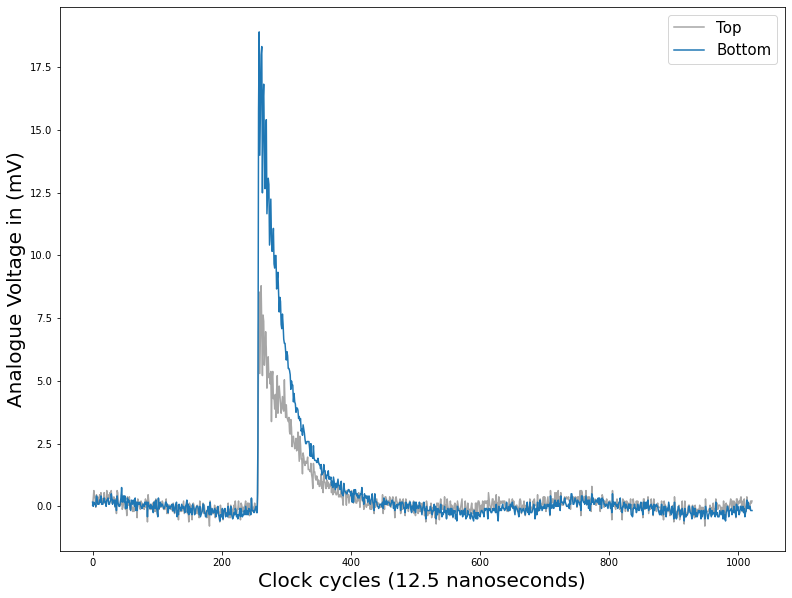

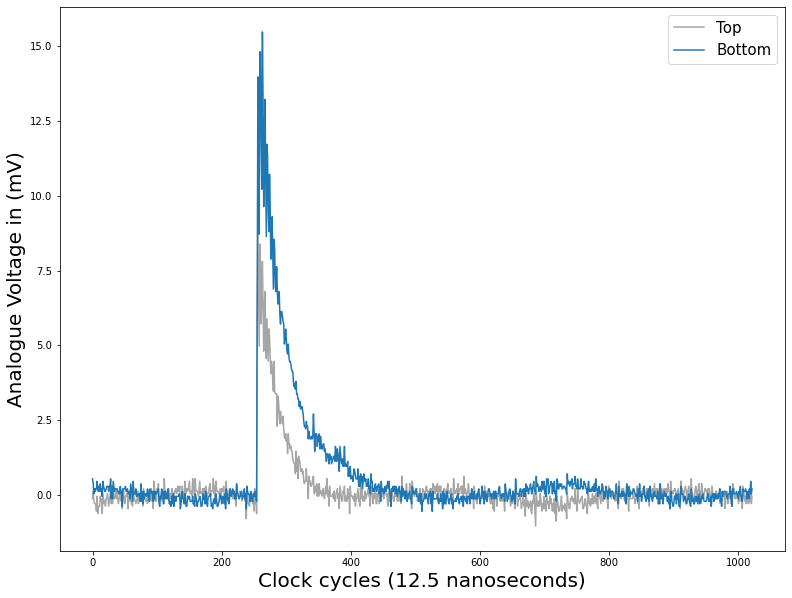

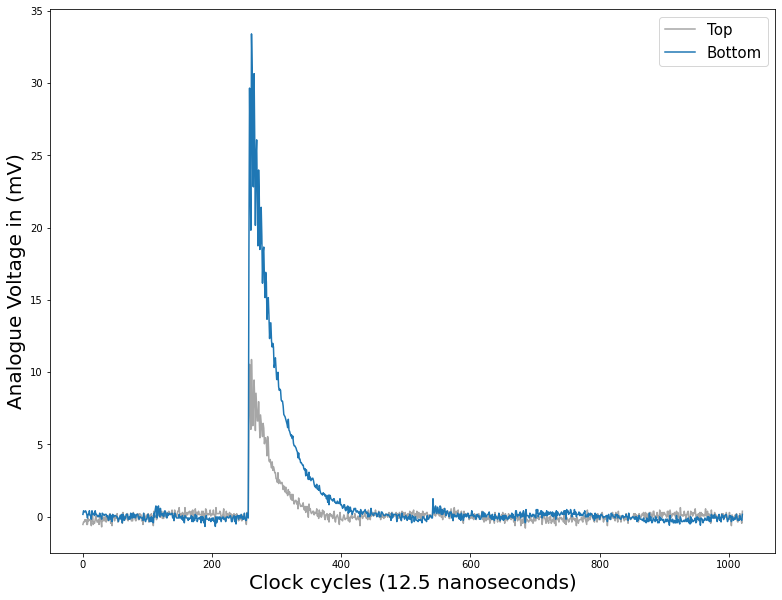

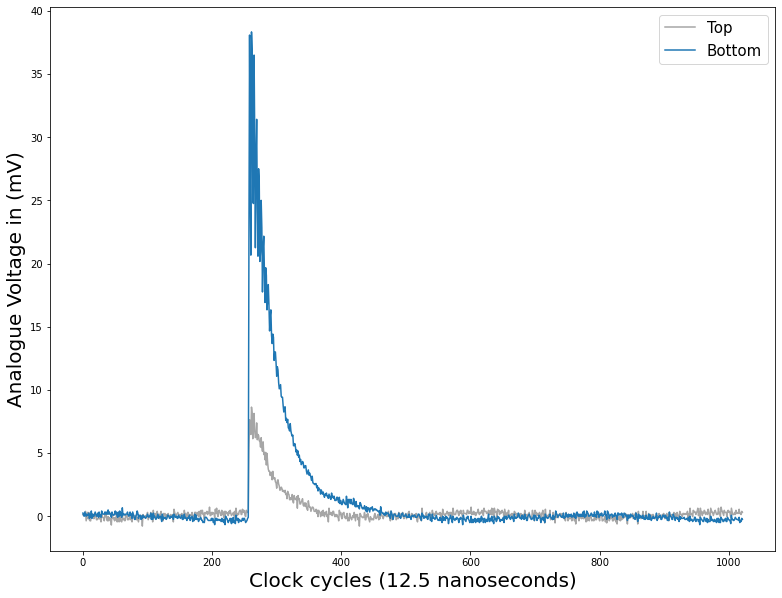

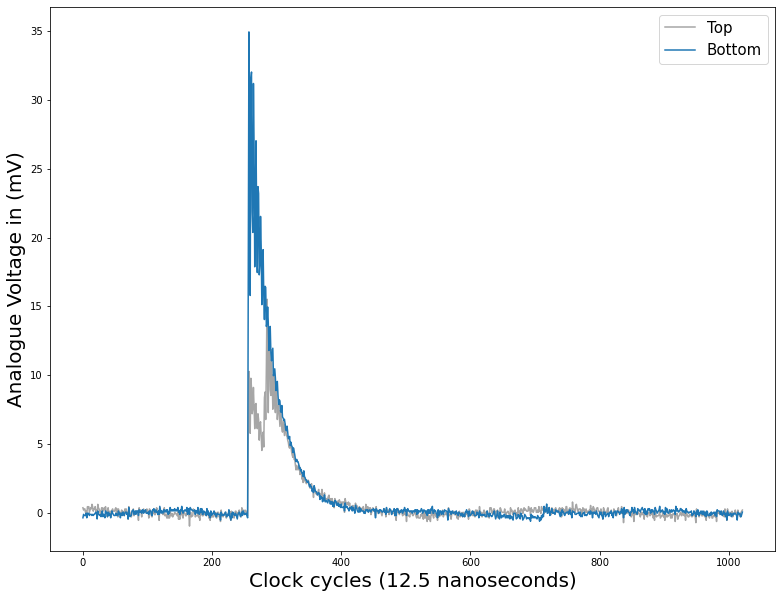

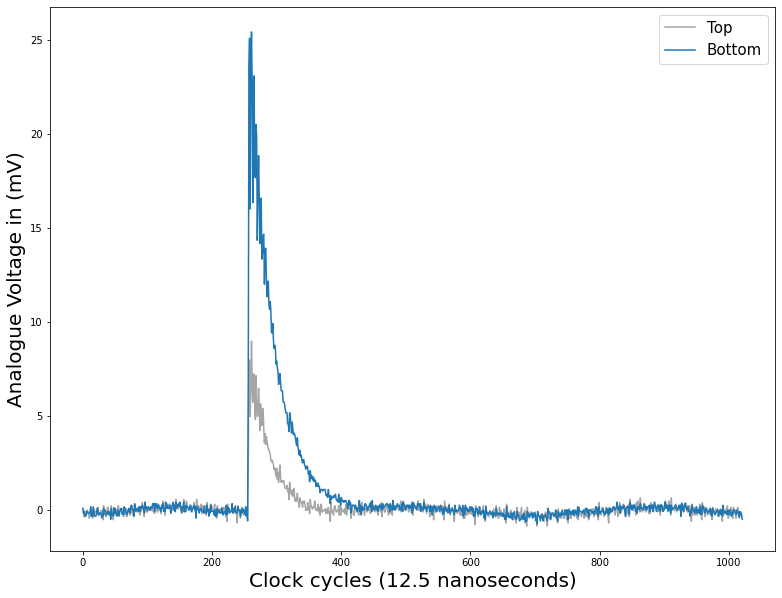

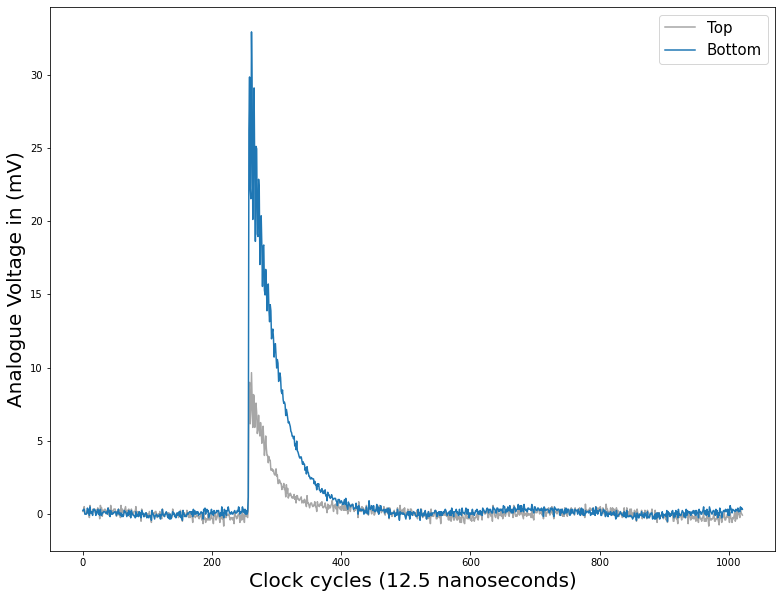

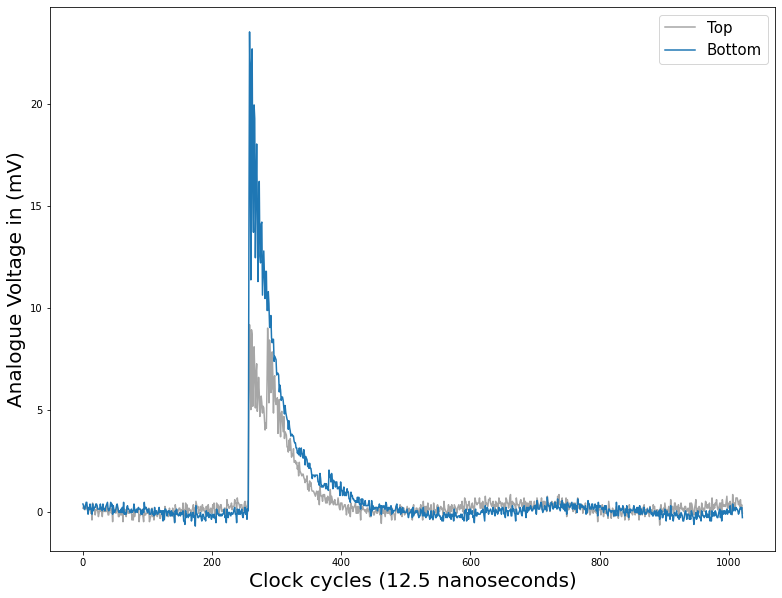

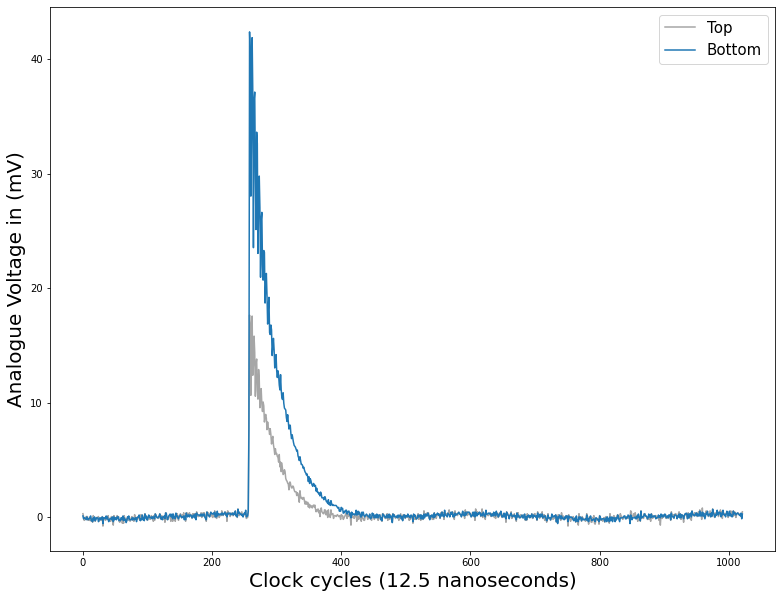

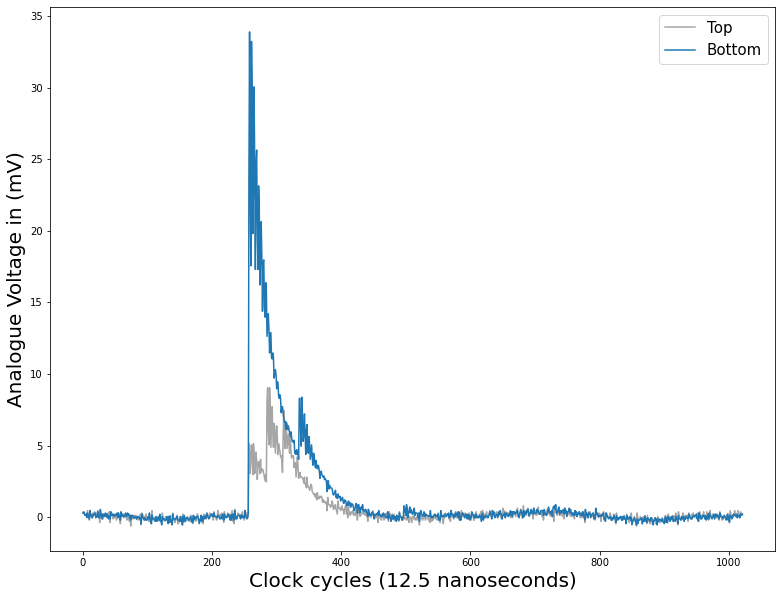

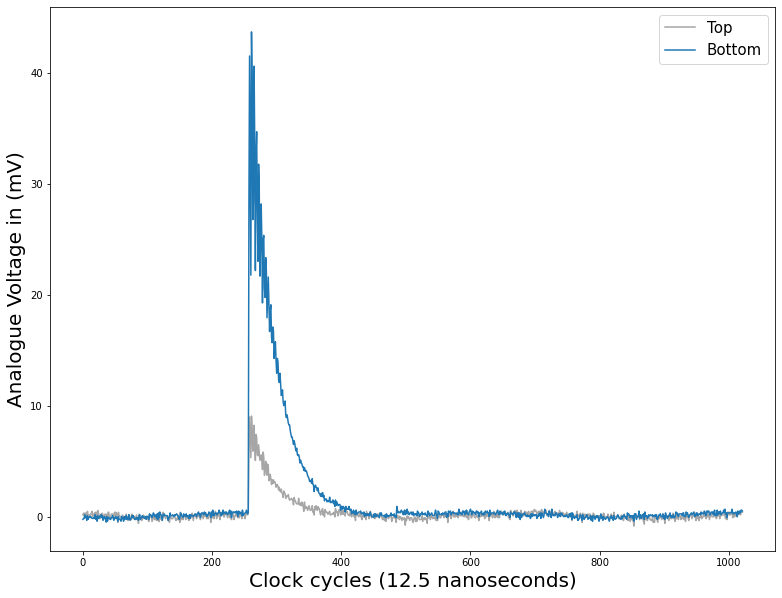

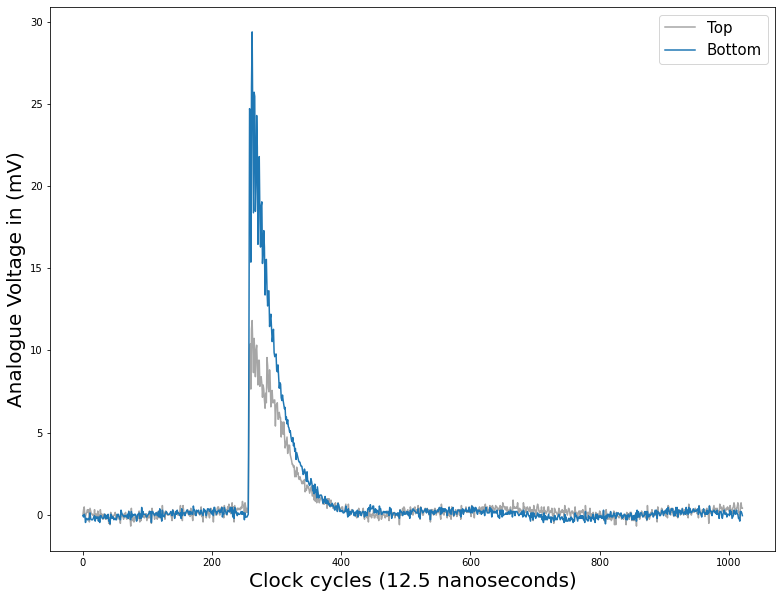

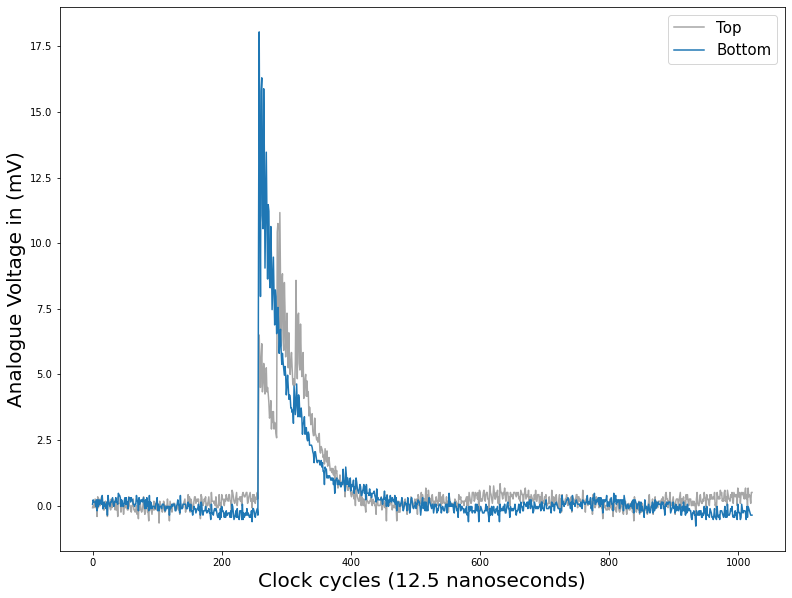

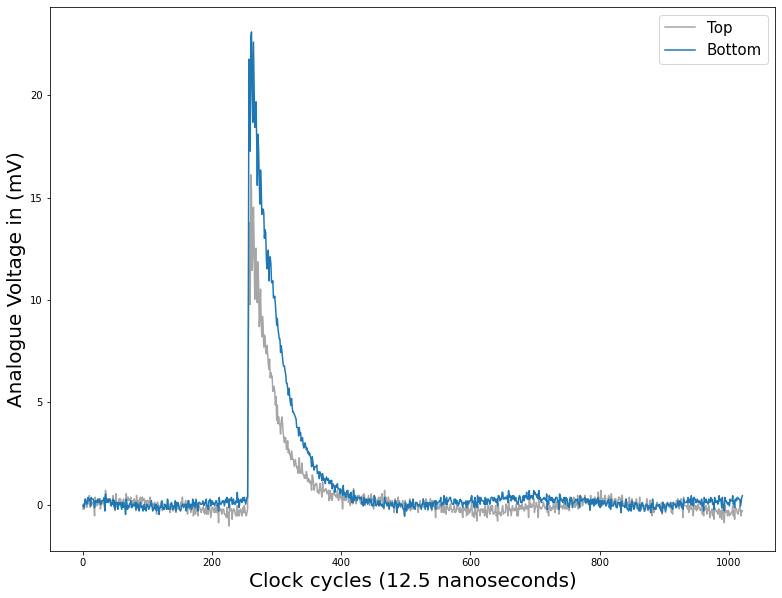

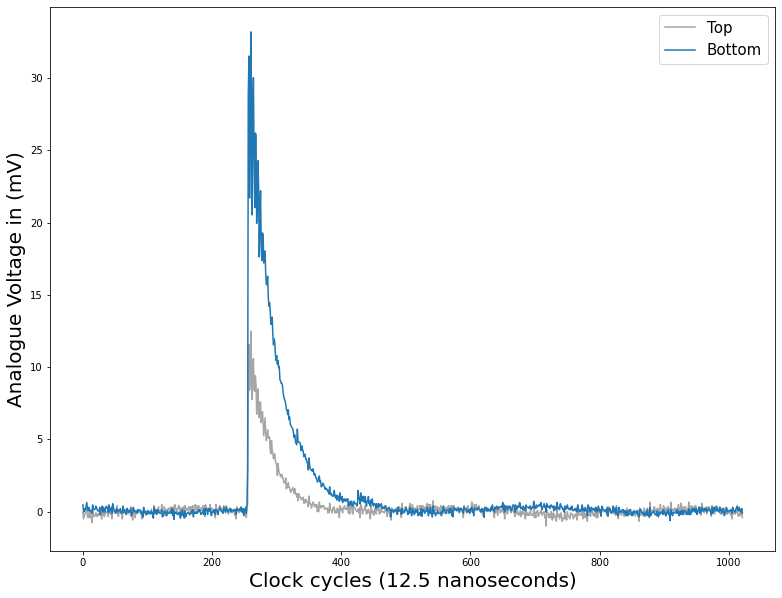

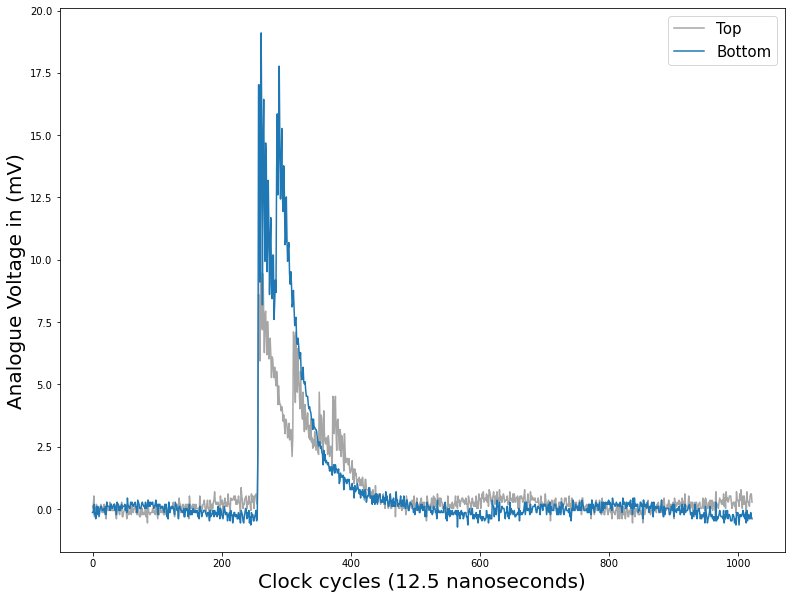

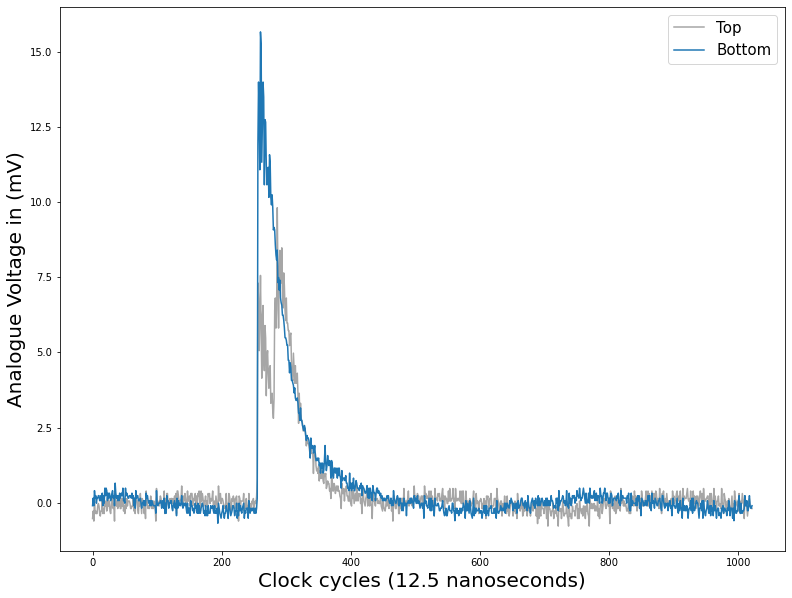

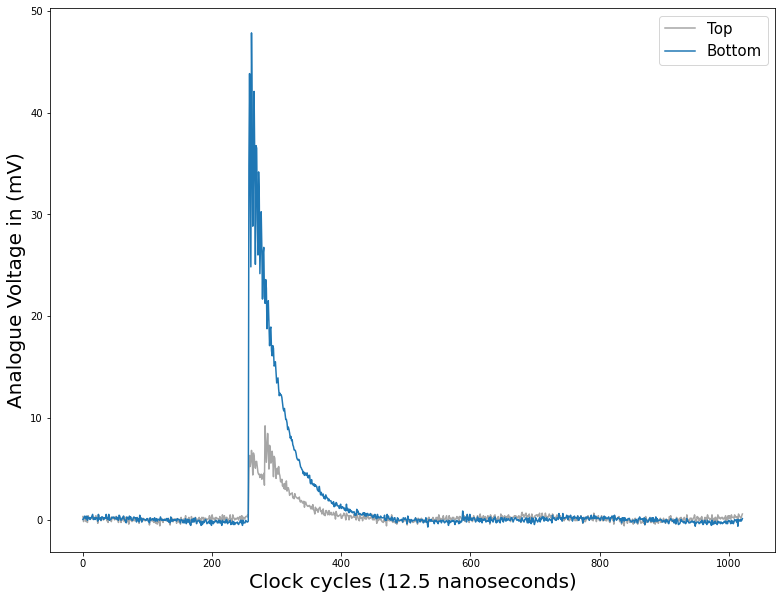

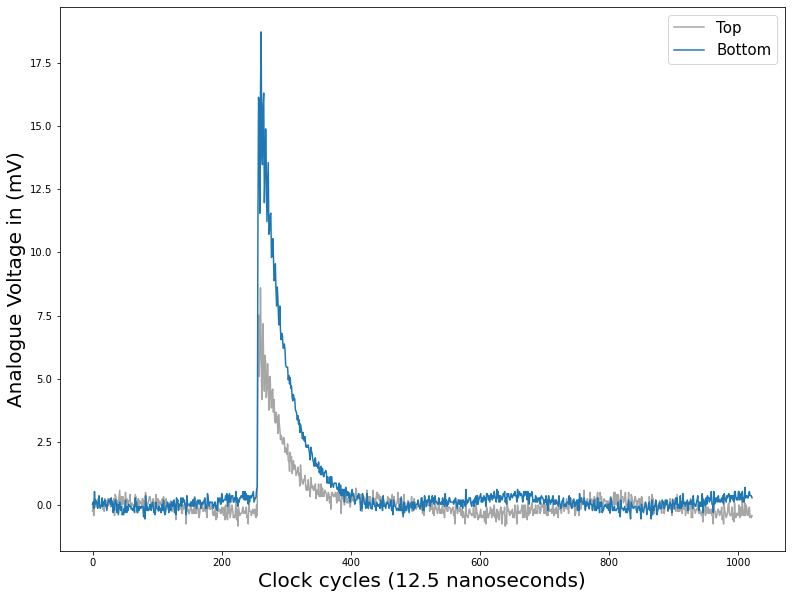

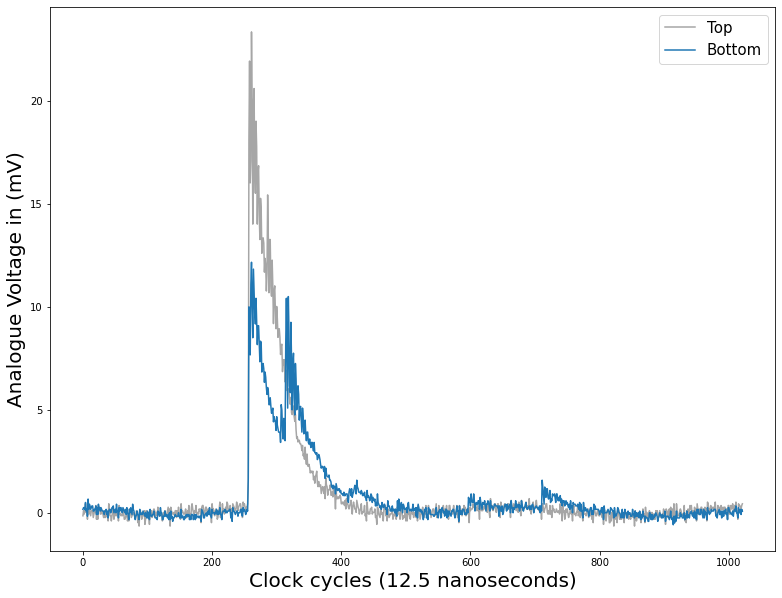

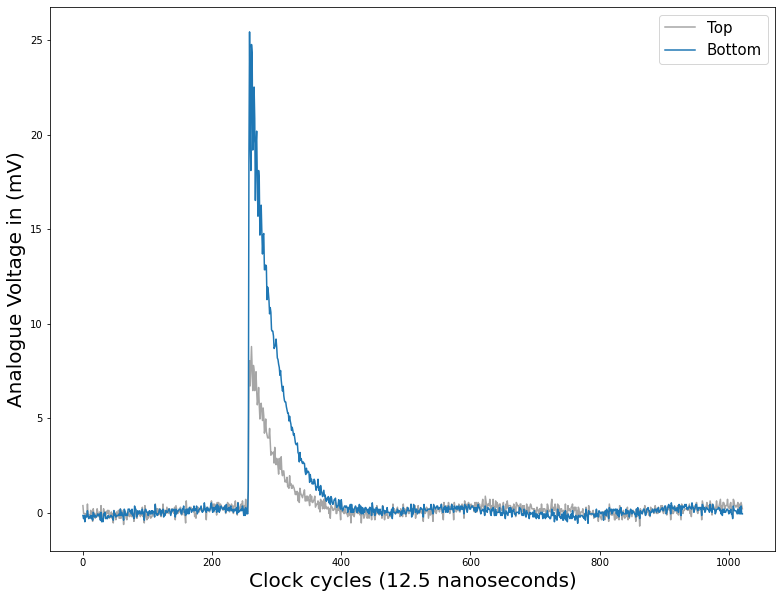

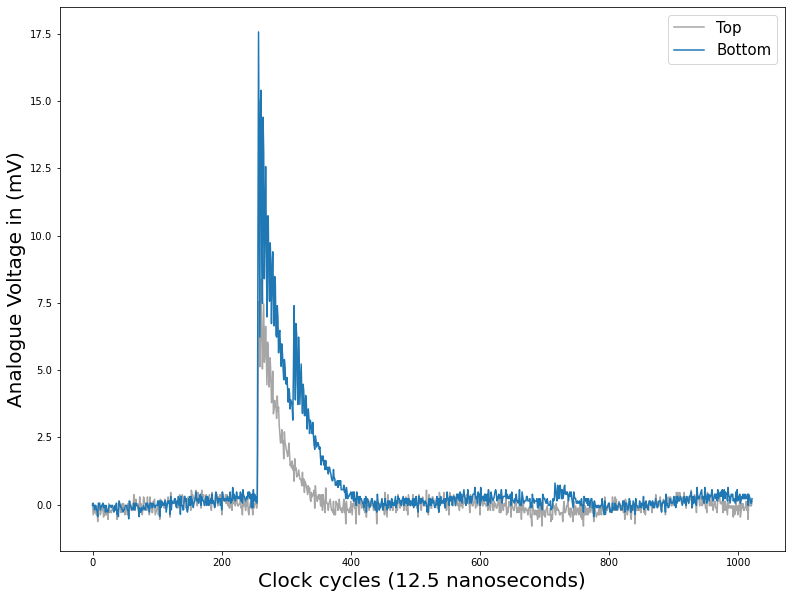

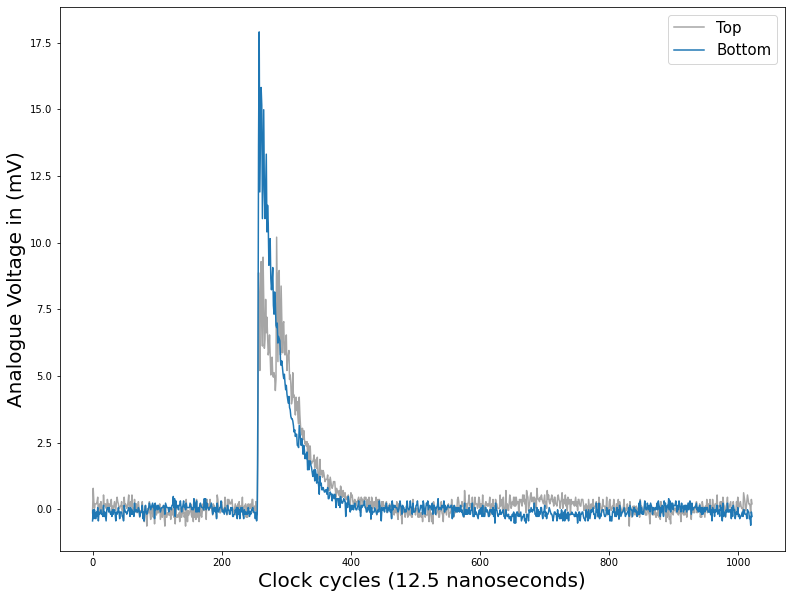

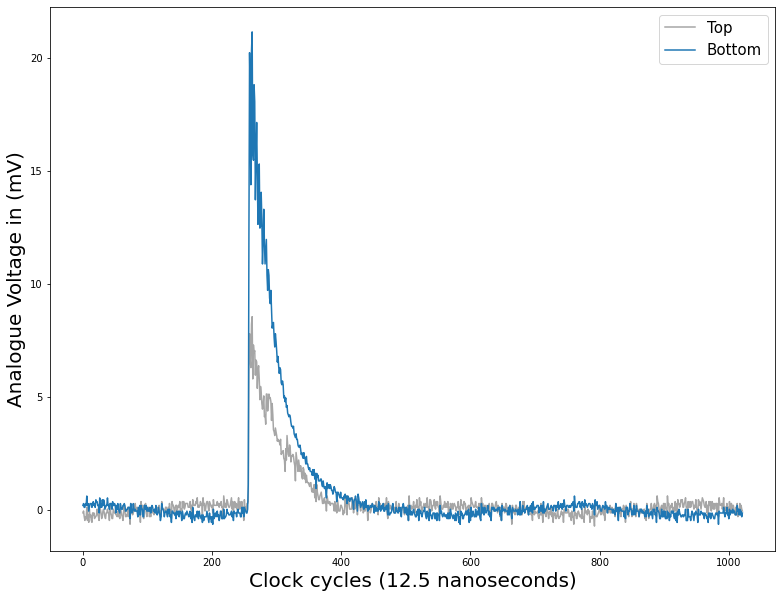

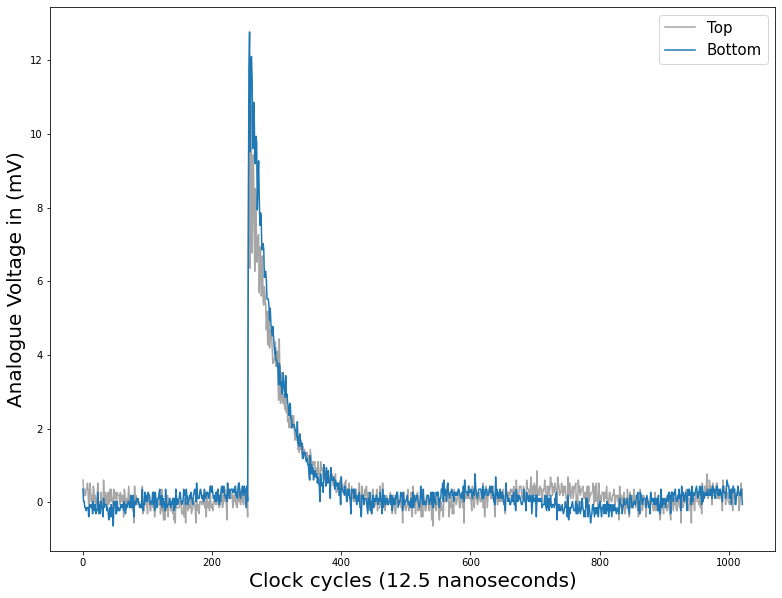

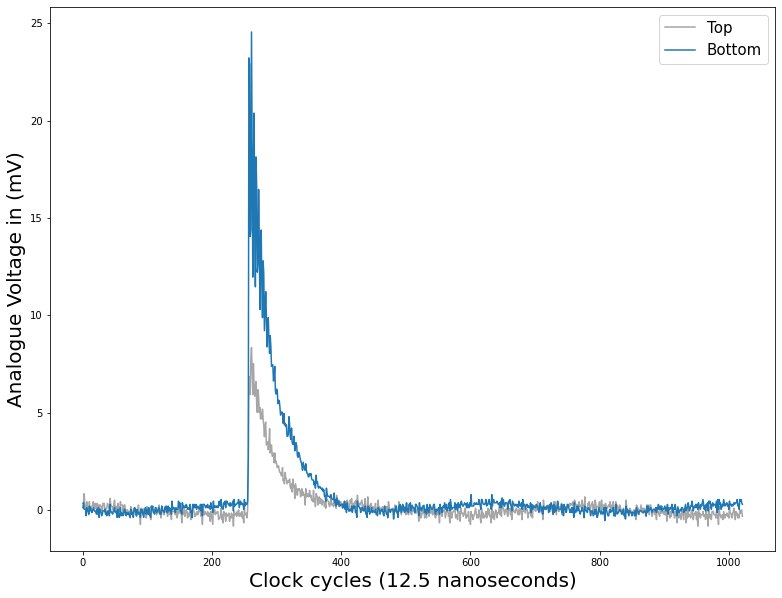

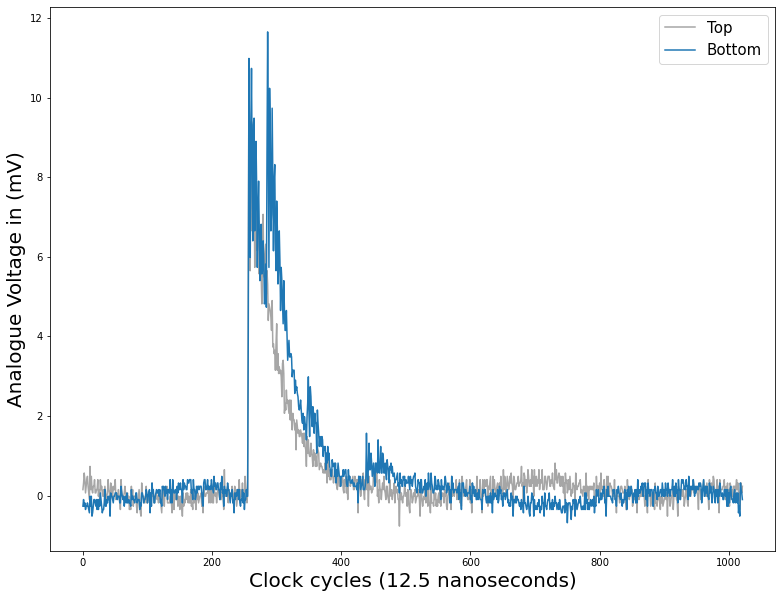

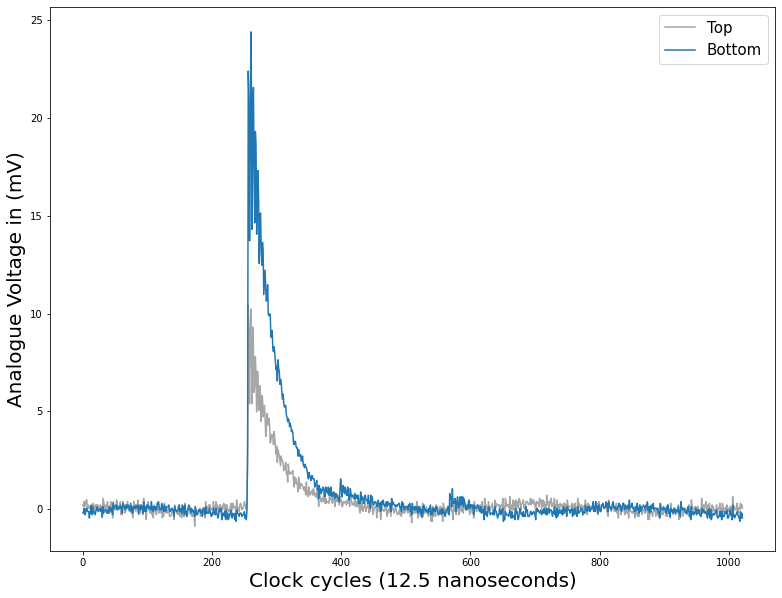

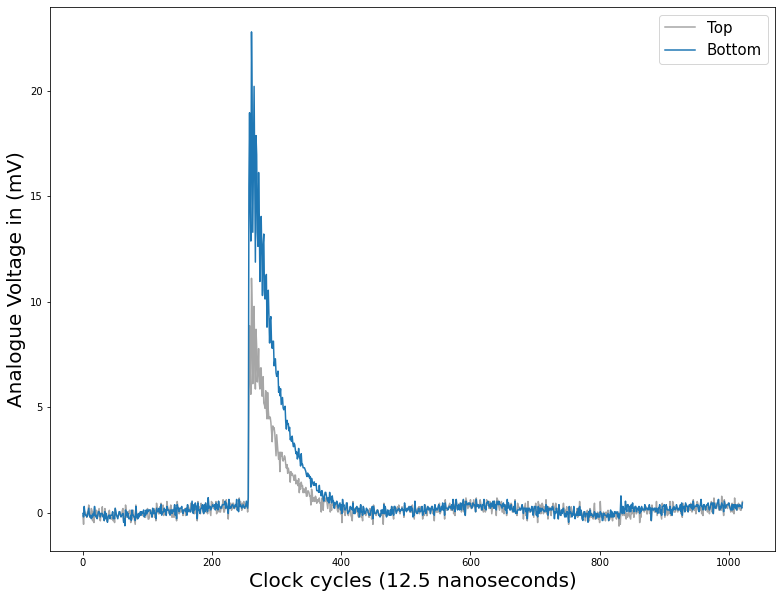

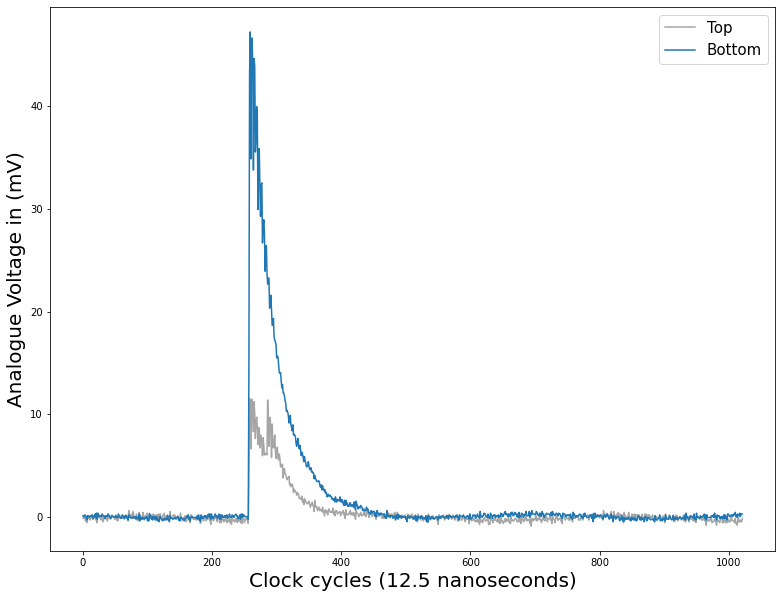

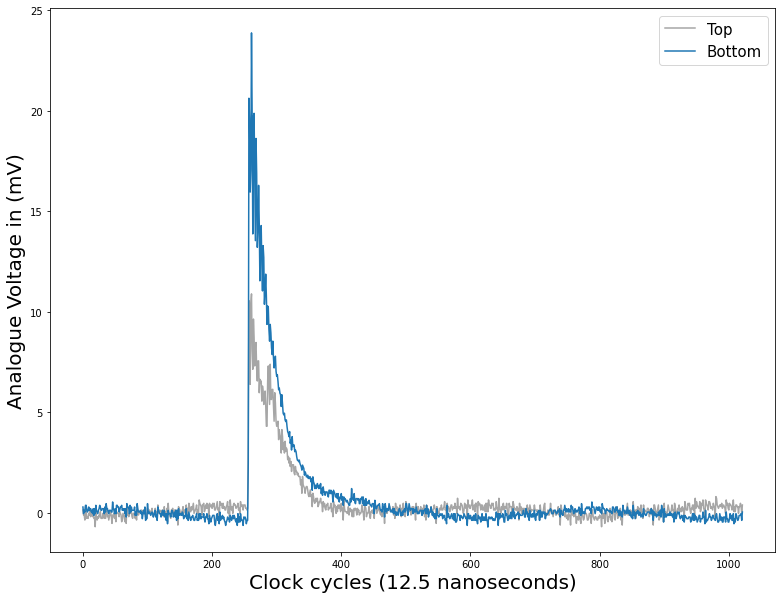

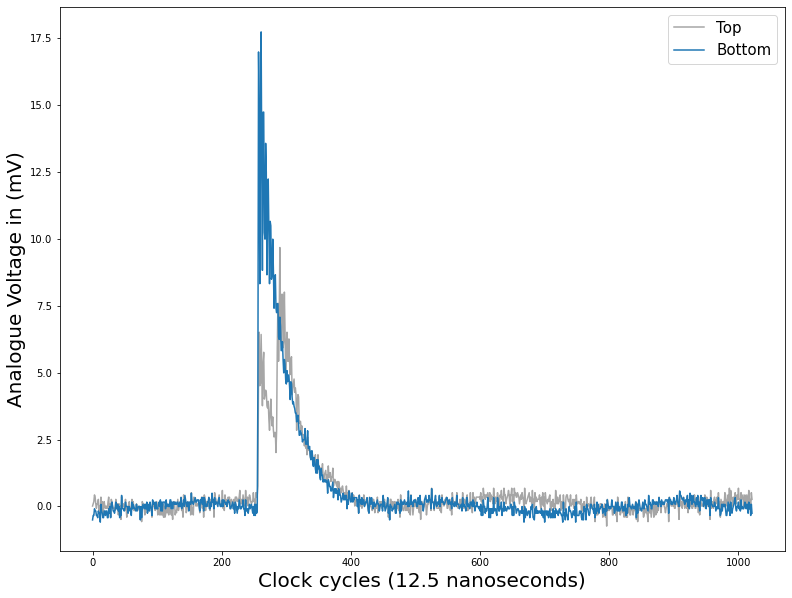

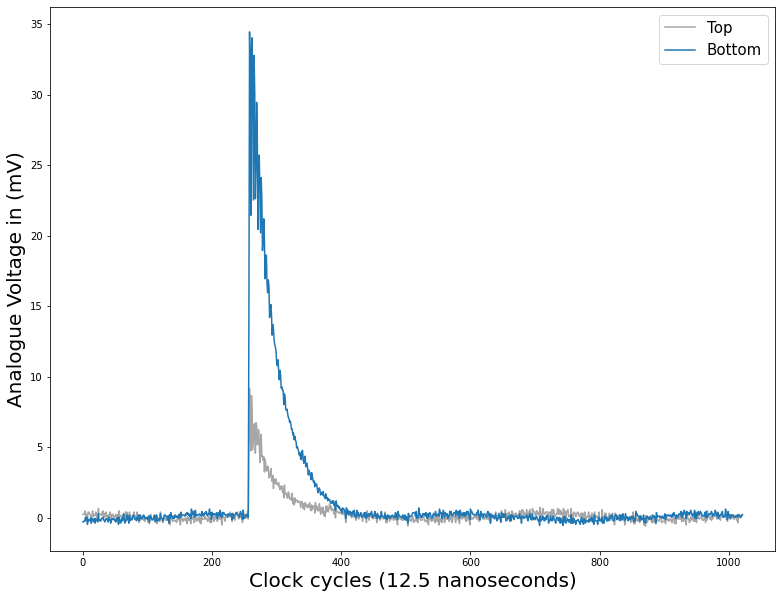

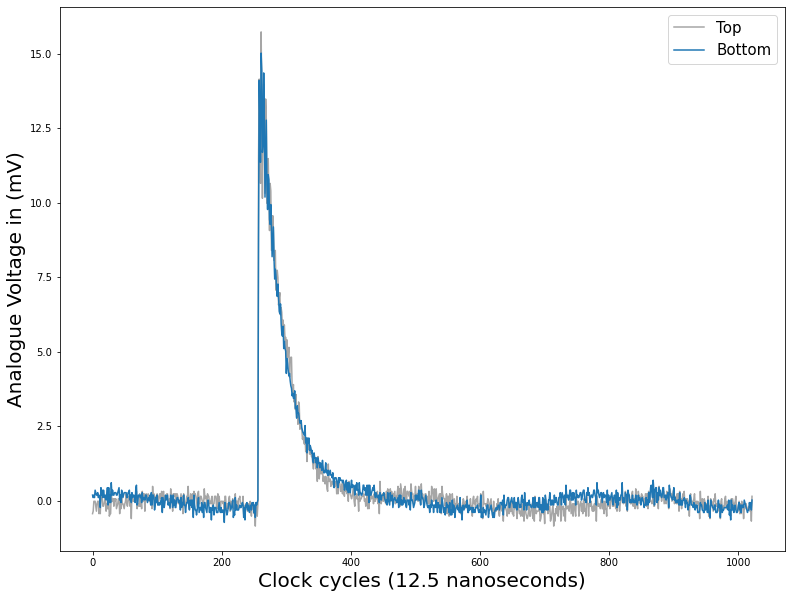

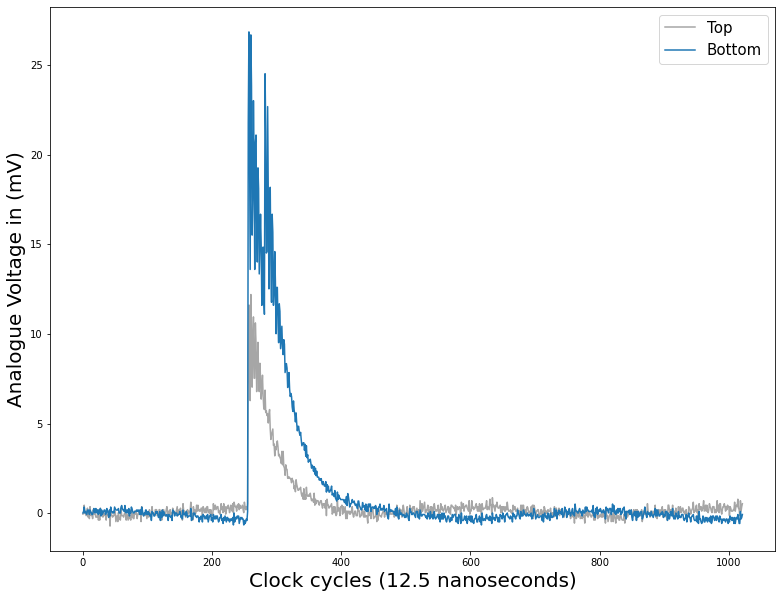

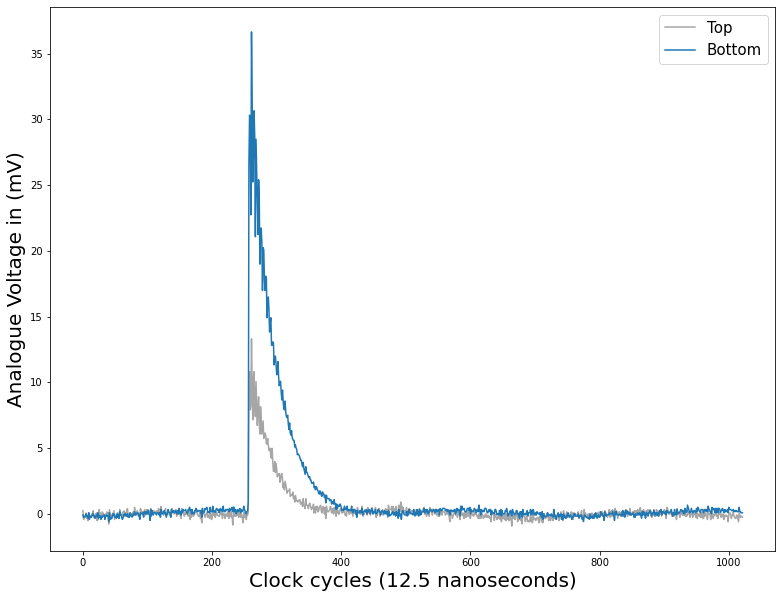

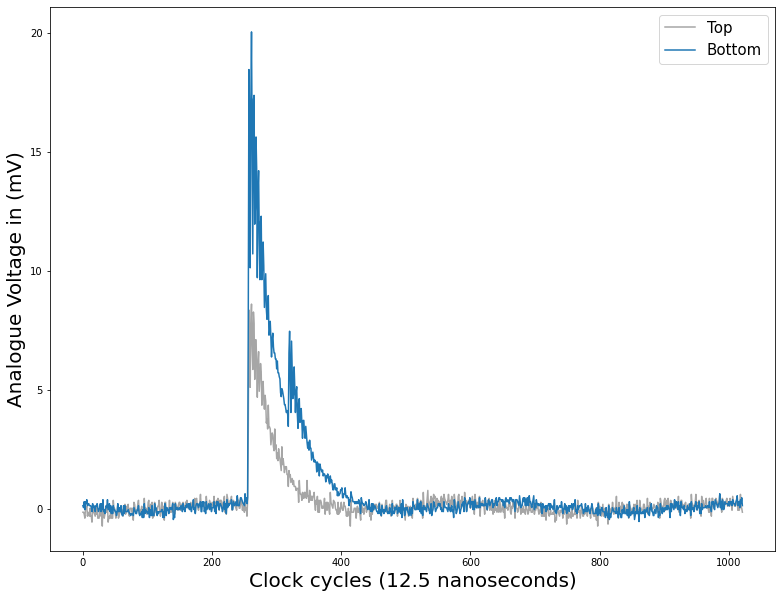

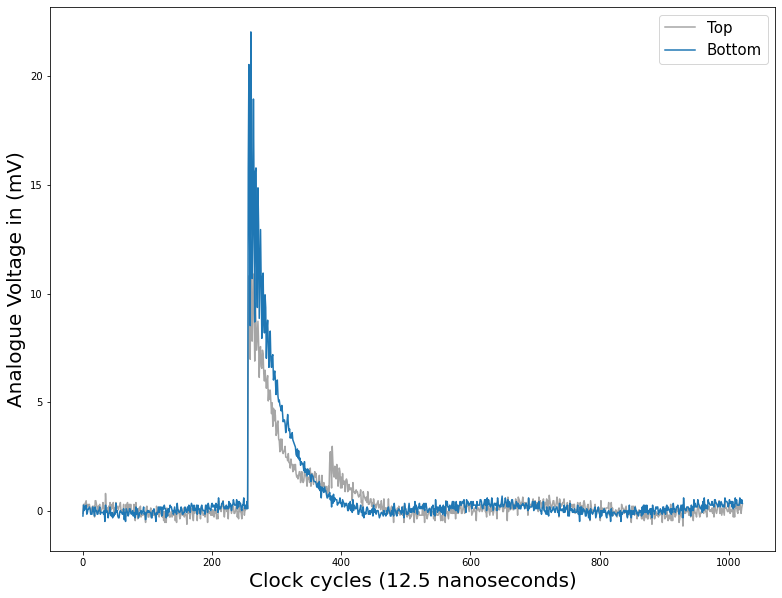

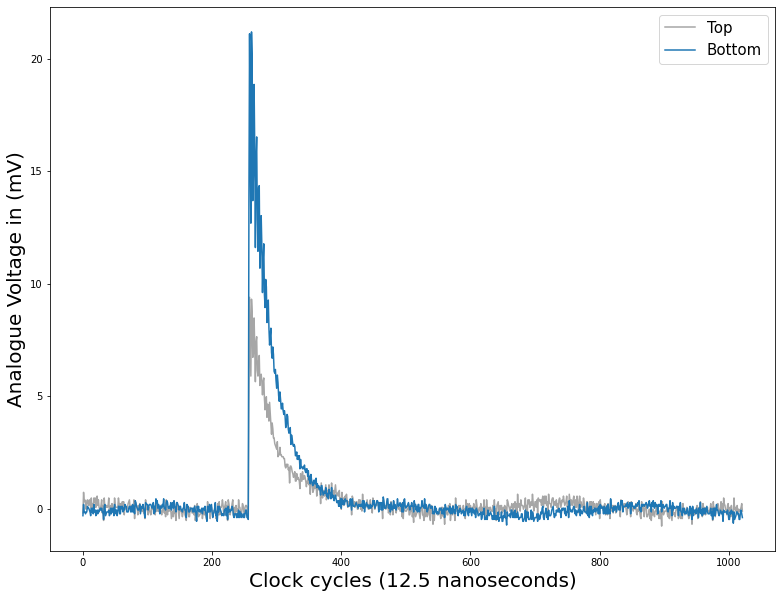

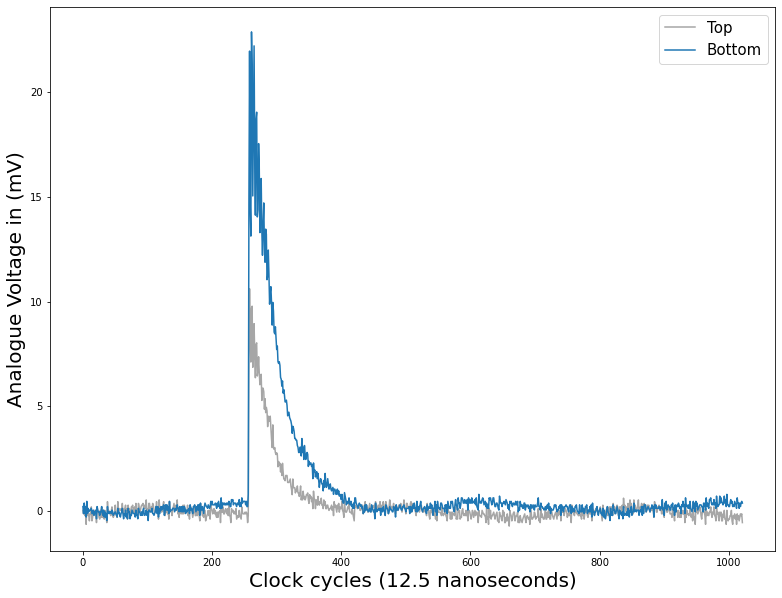

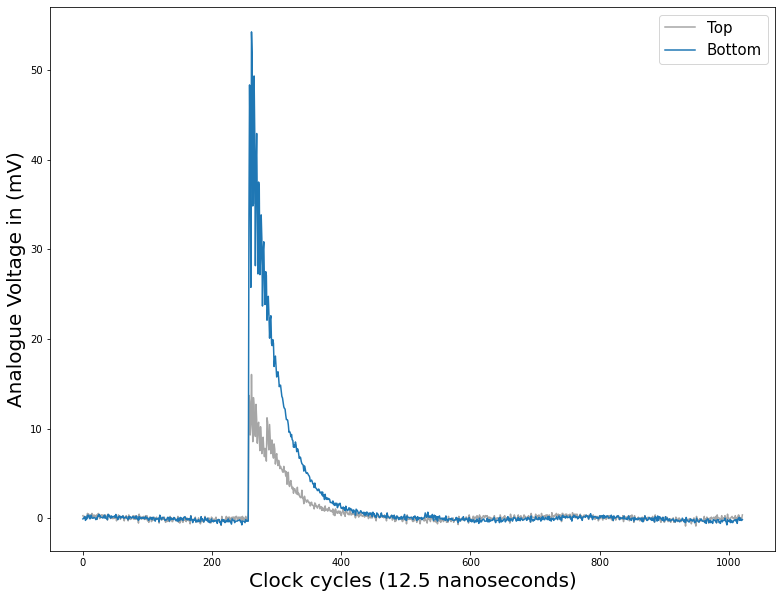

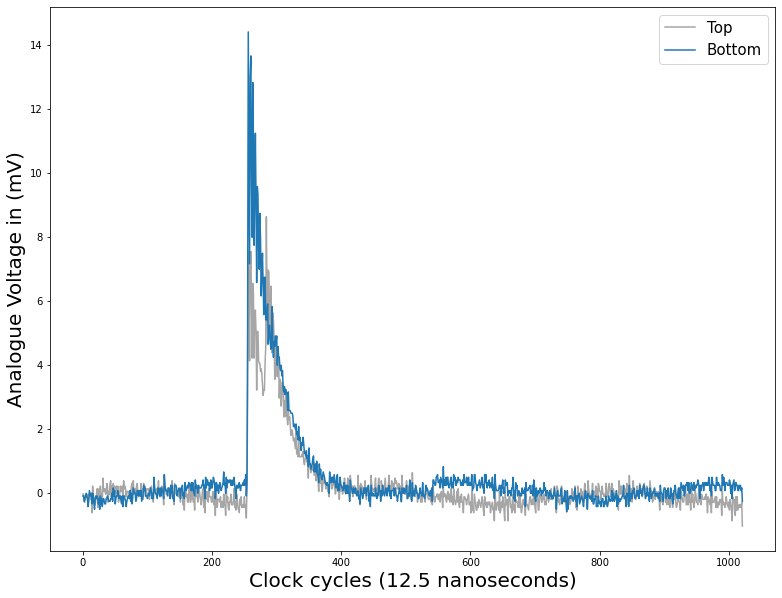

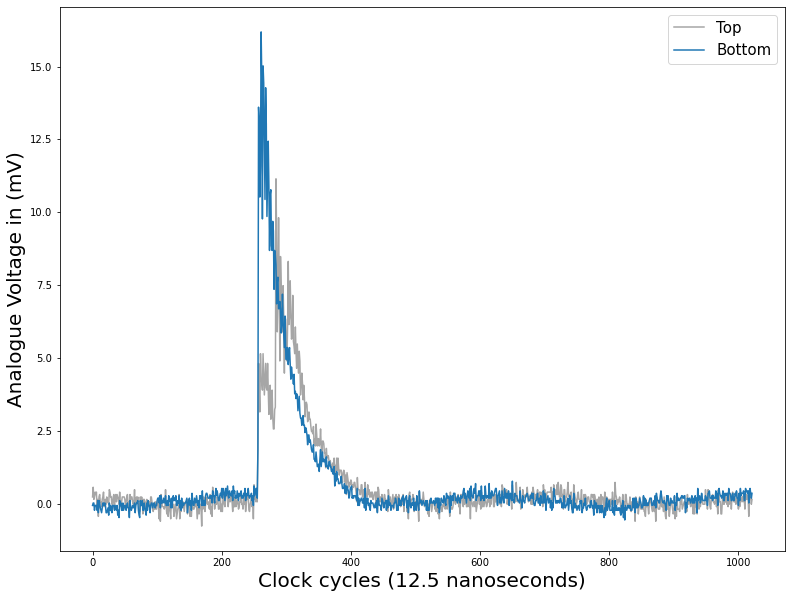

In [ ]:
for i in range(50):
    plt.figure(figsize = (13,10))
    plt.plot(bov_cutoff_list[i]/12, label = 'Top', alpha = 0.7, color = 'gray')
    plt.plot(ond_cutoff_list[i]/12, label = 'Bottom')
    plt.xlabel("Clock cycles (12.5 nanoseconds)", fontsize = 20)
    plt.ylabel("Analogue Voltage in (mV)", fontsize = 20)
    plt.legend(prop={'size':15})
    plt.show()

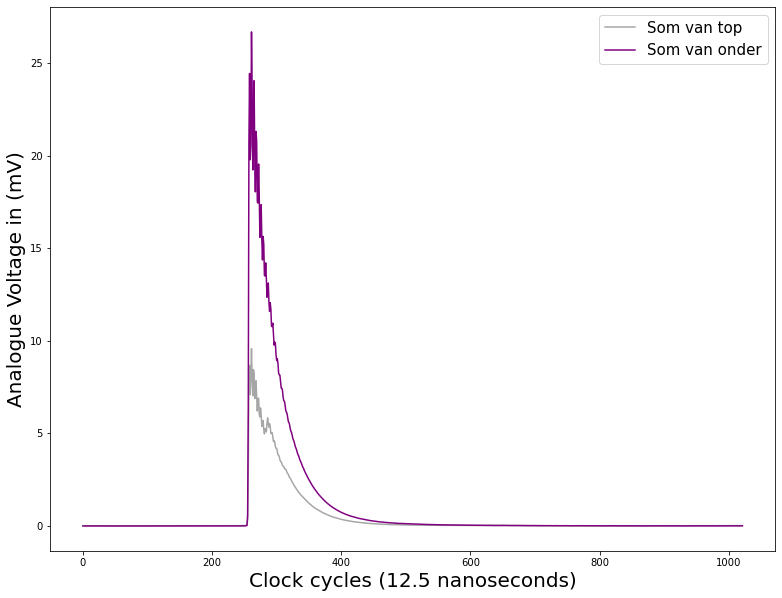

In [ ]:
plt.figure(figsize = (13,10))
som_onder = sum(ond_cutoff_list)/len(ond_cutoff_list)
som_top = sum(bov_cutoff_list)/len(bov_cutoff_list)

peaks = find_peaks(som_top, height = 30, distance = 10, prominence = 1)

# plt.axvline(x = peaks[0][2], color = 'navy', linestyle = 'dashed', label='Weird peak/reflection')
plt.plot(som_top/12, label = 'Som van top', alpha = 0.7, color = 'gray')
plt.plot(som_onder/12, label = 'Som van onder', color = 'purple')
plt.xlabel("Clock cycles (12.5 nanoseconds)", fontsize= 20)
plt.ylabel("Analogue Voltage in (mV)", fontsize= 20)
plt.legend(prop={'size':15})
plt.savefig('New_Som_plot.pdf')
plt.show()

In [ ]:
print(counter)

364111


In [ ]:
def find_peaks_data(ond_cutoff_list, bov_cutoff_list, n, weird_peak_start, plot):
    distance_list = []
    event_counter = 0
    first_peak = 260
    energy_electron = []
    for i in range(n):
        weird_peak = weird_peak_start
        peaks = find_peaks(ond_cutoff_list[i][weird_peak:], height = 15, prominence = 30)
        if len(peaks[0]) == 1:
            if peaks[0][0]+weird_peak+ 10 > 1021 or peaks[0][0]+weird_peak- 10 > 1021:
                weird_peak = weird_peak - 10
            if bov_cutoff_list[i][peaks[0][0]+weird_peak+10] < 15: 
                distance = peaks[0][0]+weird_peak-first_peak
                distance_list.append(distance)
                event_counter += 1

                energy_electron.append(np.trapz(bov_cutoff_list[i][peaks[0][0]:peaks[0][0]+200]))

                if plot:
                    plt.figure(figsize = (13,10))
                    plt.axvline(x = first_peak, color = 'k', linestyle = 'dashed')
                    plt.axvline(x = peaks[0][0]+weird_peak, color = 'k', linestyle = 'dashed')
                    print("JA", len(peaks[0]))
                    plt.plot(bov_cutoff_list[i]/12, label = 'Top', alpha = 0.7, color = 'gray')
                    plt.plot(ond_cutoff_list[i]/12, label = 'Bottom')
                    plt.xlabel("Clock cycles (12.5 nanoseconds)", fontsize = 20)
                    plt.ylabel("Analogue Voltage (in mV)", fontsize = 20)
                    plt.legend(prop={'size':15})
                    plt.show()

    print(event_counter)
    plt.figure(figsize = (10,6))
#     plt.axvline(x=75, color = 'k')
    plt.hist(distance_list, 50)
    plt.xlabel("Time in clockcycles between muon and electron peaks", fontsize =15)
    plt.ylabel("Number of events", fontsize =15)
    plt.xlim(0,750)
    plt.savefig('Completedistribution.pdf')
    plt.show()
    
    return distance_list, energy_electron

1006


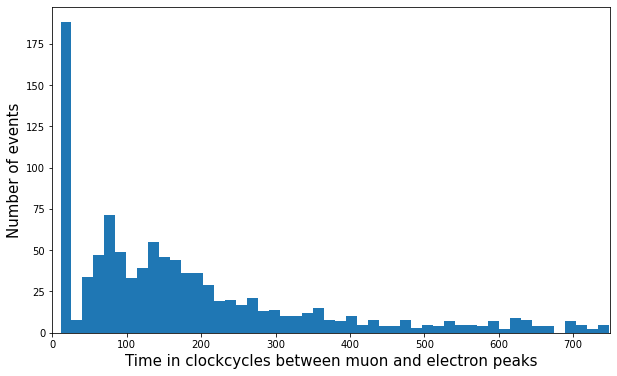

In [ ]:
distance_list, energy_electron = find_peaks_data(ond_cutoff_list, bov_cutoff_list, counter, 270, plot = False)

In [ ]:
print(len(distance_list))

np.savetxt('500k_with_new_detector.txt', distance_list)

In [ ]:
old_setup_dist_list = oude_grote_event_list
new_test = []

for i in range(len(old_setup_dist_list)):
    if old_setup_dist_list[i] >= 40:
        new_test.append(old_setup_dist_list[i])
        
print(len(new_test))
    
new_setup_dist_list = distance_list
# 
print(len(old_setup_dist_list))
print(len(new_setup_dist_list))


all_distance_list = new_test+new_setup_dist_list

print(len(all_distance_list))

1482
1531
5012
6494


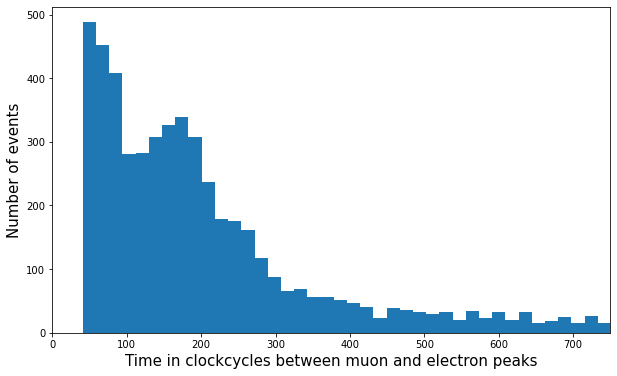

In [ ]:
plt.figure(figsize = (10,6))
#     plt.axvline(x=75, color = 'k')
plt.hist(distance_list, 40)
plt.xlabel("Time in clockcycles between muon and electron peaks", fontsize =15)
plt.ylabel("Number of events", fontsize =15)
plt.xlim(0,750)
plt.savefig('Cutoff300distribution.pdf')
plt.show()

In [ ]:
distance_list = all_distance_list

In [ ]:
def exponential(t, parm):
    noise_offset = parm[0]
    N0 = parm[1]
    labda = parm[2]
    
    return noise_offset + N0 * np.exp(-t*labda) 

def gaussian_model(t, parm):
    n_total = parm[0]
    e_cent = parm[1]
    sigma = parm[2]
    return (n_total/(sigma*(2*np.pi)**0.5)) * np.exp((-(energy_values - e_cent)**2)/(2*sigma**2))

def combined_model(t, parm):
    return gaussian_model(t, parm) + exponential(t, parm[-3:])

def model_int_cf(ecent, ebins, model, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.
       Inputs:
           ecent - energy bin centres, dummy array with length len(ebins)-1 to fool curve_fit into 
                   accepting the function as the correct format for curve_fit.
           ebins - energy bin edges.
           model, parm - the curve_fit model name and input parameter list.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

def histrebin(mininbin,counts,edges):
    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays'''
    
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
            
    return counts2, edges2

def plot_spec_model(ebins,cdens,cdens_err,cdens_model):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.'''
    
    color_list = ['blue', 'orange', 'green', 'red', 'yellow']
    
    energies = (ebins[1:]+ebins[:-1])/2
    bwidths = np.diff(ebins)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,9),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='.', label='Bin values')
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights = cdens_model, density= False, histtype='step', label='Fit')
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='.', label ='Bin values')
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax2.set_xlabel('Time in seconds', fontsize = 20)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax1.set_ylabel('Normalised events/bin', fontsize = 20)
    ax2.set_ylabel('Data/model', fontsize = 15)
    ax2.tick_params(labelsize=14)
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
#     ax2.set_xlim(ebins[0],ebins[-1]) # Strictly speaking we should only show the energy range 
    # where data is sampled, to avoid impression from model that the flux suddenly drops 
    ax1.set_title('Fitted model to the rebinned energy event data', fontsize = 14)
    ax1.legend(prop={'size':15})
    plt.savefig('Fitthrough300cutoff.pdf')
    # at the boundaries.
#     plt.show()
    
    return energies, (np.abs(cdens/cdens_model-1)/(cdens_err/cdens_model))
    
def plot_fit(model, p0, var_dict, counts2, edges2, bwidths, cdens, cdens_err, energies, plot):
    """ calculates and prints the MLEs for the parameters, 
        plots the fit as a histogram through the binned data,
        calculates and prints the minimum chi^2 and the goodness of fit
    :param model: the curve_fit model name
    :param p0: the initial guesses for the parameters
    :param var_dict: a dictionary of the variable names of the parameters
    :param counts2: the rebinned count array
    :param edges2: the rebinned edge array
    :param bwidths: bin width
    :param cdens: count density array of each bin
    :param cdens_err: count density error array of each bin
    :param energies: energy value array of the points
    :return: the values and their positions with larger deviations from the model than 2 sigma
    """
    
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                            energies, cdens, p0, sigma=cdens_err)

    #use the covariance matrix to find the errors
    err = np.sqrt(np.diag(ml_cfcovar)) 
    
    print(1/ml_cfpars[2] * 1e6, '+/-', 1/ml_cfpars[2] * 1e6*(err[2]/ml_cfpars[2]))

    best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
    
    #plots the model and returns the energy of each point and its error bar
    if plot:
        energies_of_points, error_bar_from_model = plot_spec_model(edges2,cdens,cdens_err,best_model)
    
#     #prints the found MLEs
#     for i in range(len(p0)):
#         print("Variable {} = ".format(var_dict[i]) + str(ml_cfpars[i]) + " +/- " + str(err[i]))
    
    minchisq = np.sum(((cdens-model(energies,ml_cfpars))/cdens_err)**2)
    dof = len(energies)-len(p0)

    return ml_cfpars, best_model, err, minchisq, edges2,cdens,cdens_err,best_model

def fit_gaussian_to_dataset(dataset, bins, plot=True):
    """ plots the data into rebinned bins
        fits and plots a straight power-law model to the rebinned data
        fits and plots a straight power-law model plus a gaussian line feature to the rebinned data
    :param dataset: the input data to be rebinned and fitted 
    :param location: a guess of the location of the gaussian line feature
    :return ml_cfpars: the MLEs of the parameters
    :return err: the errors on the MLE of the parameters
    :return minchisq_pl: the minimum chi-squared for the single power-law model
    :return minchisq_pl_gaus: the minimum chi-squared for the power-law + gaussian model
    """ 
    nbins = bins
    counts, edges = np.histogram(dataset, bins=nbins, density=False)

    #rebin the data into different bins and counts
    mincounts = 10
    counts2, edges2 = histrebin(mincounts,counts,edges)

    bwidths = np.diff(edges2) 
    cdens = counts2/bwidths 
    cdens_err = np.sqrt(counts2)/bwidths 
    energies = (edges2[:-1]+edges2[1:])/2.

    #fit the continuum power-law model plus the gaussian to the data
    ml_cfpars, best_model, err, minchisq_pl,ebins,cdens,cdens_err,cdens_model = plot_fit(exponential, [1, 1e8, 1000], {0:'Noise Offset', 1:'N0', 2:'Lambda'}, counts2, edges2, bwidths, cdens, cdens_err, energies, plot)    
    return 1/ml_cfpars[2] * 1e6, 1/ml_cfpars[2] * 1e6*(err[2]/ml_cfpars[2]), ebins,cdens,cdens_err,cdens_model

1.8365577363263013 +/- 0.10806346271721703


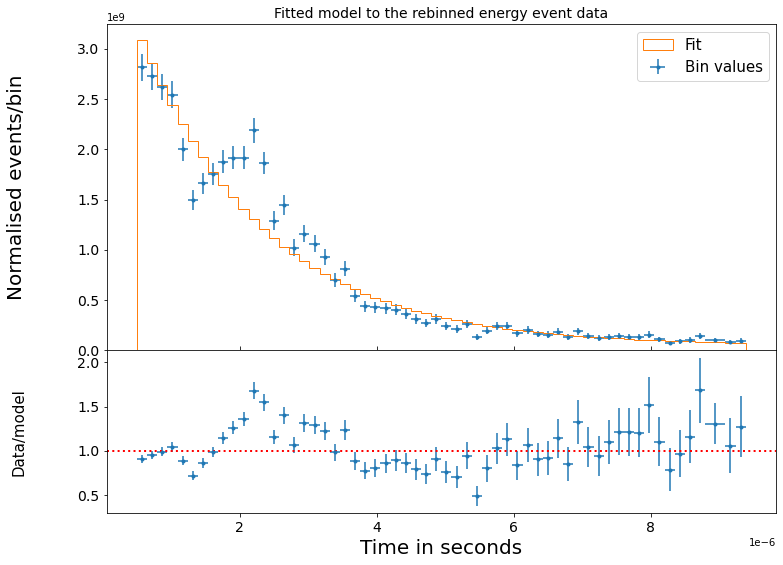

In [ ]:
lifetime, error_lifetime, ebins,cdens,cdens_err,cdens_model = fit_gaussian_to_dataset(np.array(distance_list)* 12.5 * 10**(-9), 60, plot=True)

1.8450680086154803 +/- 0.16737227828714682
1.8426482168278258 +/- 0.12424265463313784
1.8365577363263013 +/- 0.10806346271721703


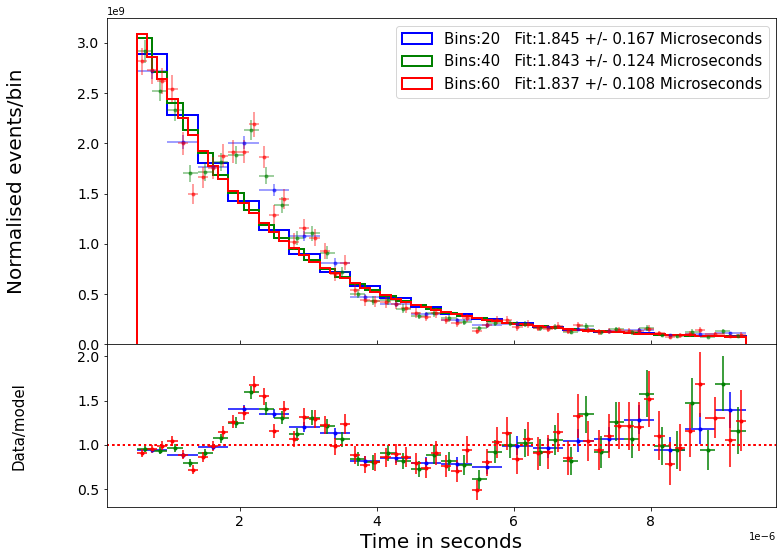

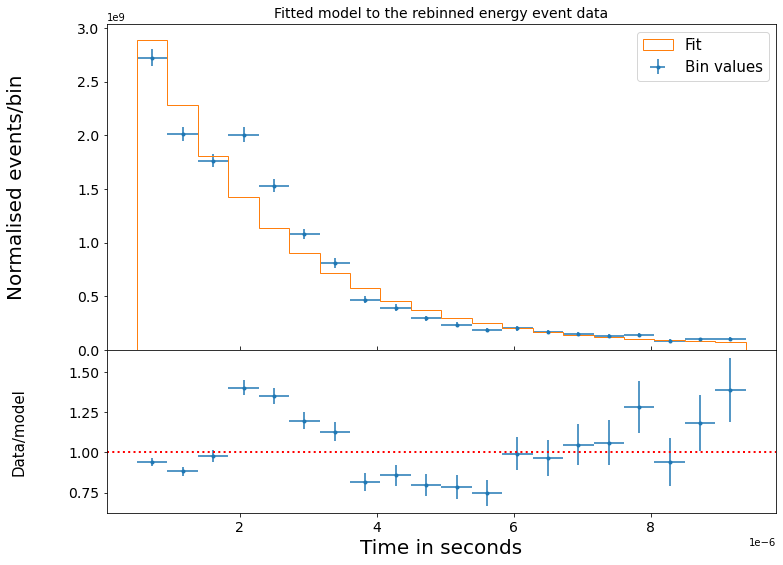

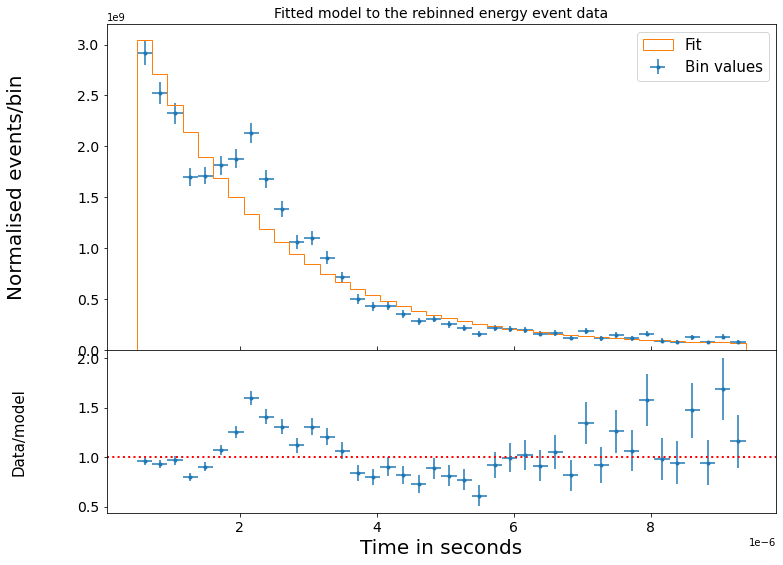

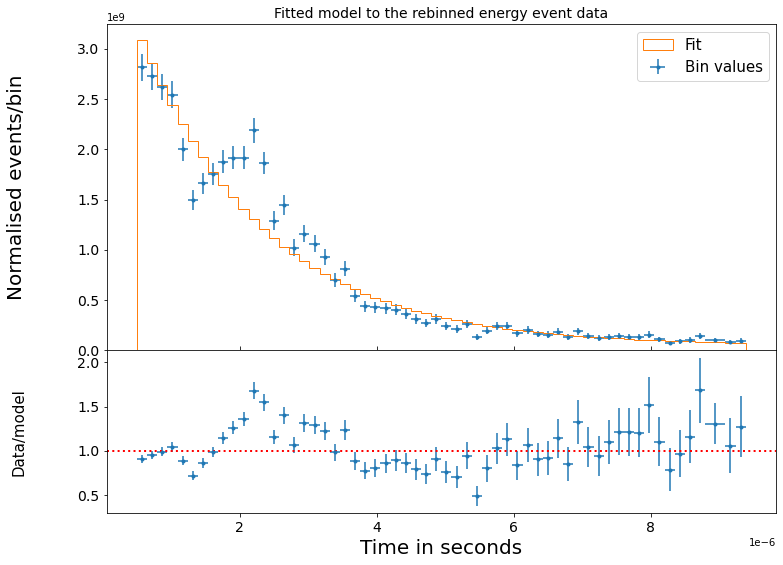

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,9),sharex=True,gridspec_kw={'height_ratios':[2,1]})
fig.subplots_adjust(hspace=0)

for i in range(3):
    lifetime, error_lifetime, ebins,cdens,cdens_err,cdens_model = fit_gaussian_to_dataset(np.array(distance_list)* 12.5 * 10**(-9), i*20+20, plot=True)

    color_list = ['blue', 'green', 'red', 'green', 'yellow']

    energies = (ebins[1:]+ebins[:-1])/2
    bwidths = np.diff(ebins)
  
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='.', color=color_list[i], alpha = 0.5)
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights = cdens_model, density= False, histtype='step',color=color_list[i], label='Bins:' +  str(i*20+20) + '   Fit:'+ str(np.round(lifetime,3)) + ' +/- ' + str(np.round(error_lifetime,3)) + ' Microseconds', linewidth = 2)
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='.',color=color_list[i])

    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
ax1.tick_params(labelsize=14)
ax2.set_xlabel('Time in seconds', fontsize = 20)
ax1.tick_params(axis="x",direction="in",which="both", length=4)
ax2.tick_params(axis="x",which="both", length=4)
ax1.set_ylabel('Normalised events/bin', fontsize = 20)
ax2.set_ylabel('Data/model', fontsize = 15)
ax2.tick_params(labelsize=14)
ax1.get_yaxis().set_label_coords(-0.12,0.5)
ax2.get_yaxis().set_label_coords(-0.12,0.5)
#     ax2.set_xlim(ebins[0],ebins[-1]) # Strictly speaking we should only show the energy range 
# where data is sampled, to avoid impression from model that the flux suddenly drops 
# ax1.set_title('Fitted model to the rebinned energy event data', fontsize = 14)
ax1.legend(prop={'size':15})
plt.savefig('bin_fit_lifetime.pdf')
# at the boundaries.
plt.show()


1.977123438073853 +/- 0.3537809270075925
1.796234096240857 +/- 0.14493580239742912
1.4627121059541082 +/- 0.12925590215615332
1.4571056001061786 +/- 0.09676698360326645
1.233116800181311 +/- 0.056661538425977424


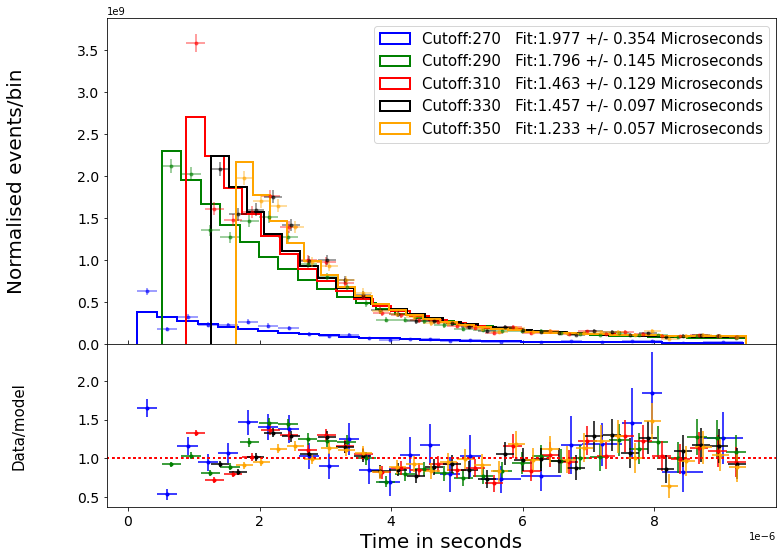

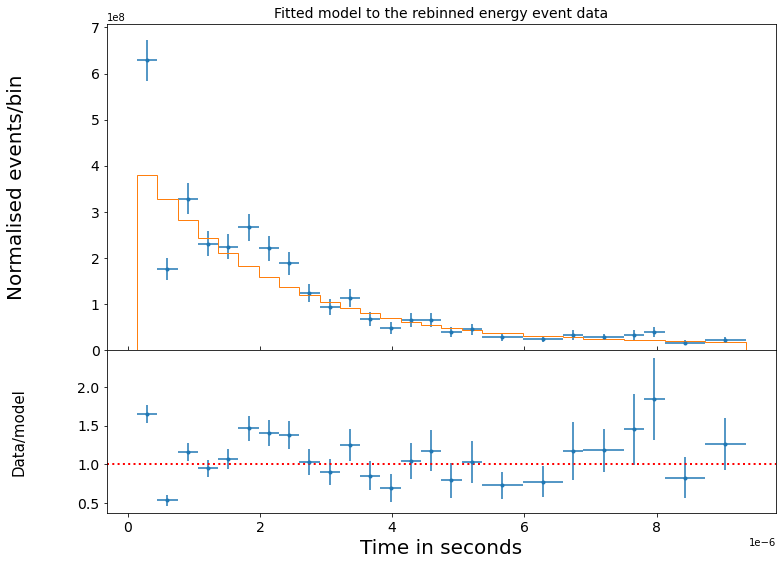

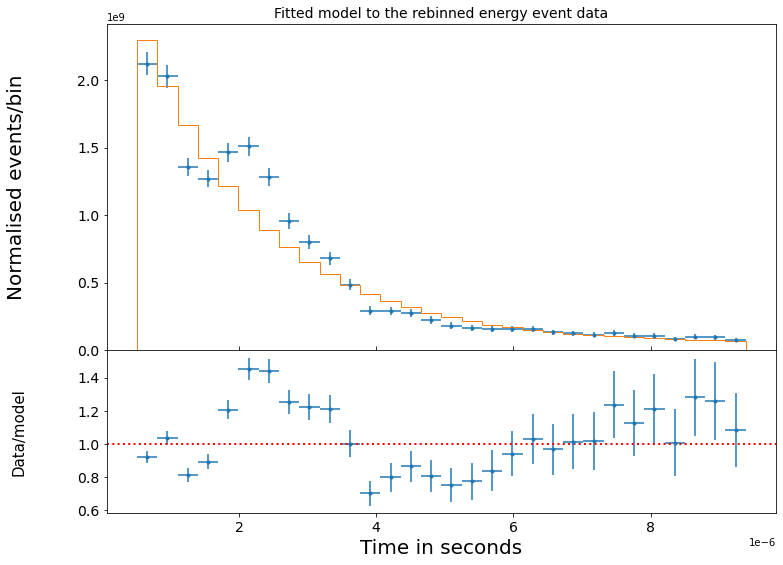

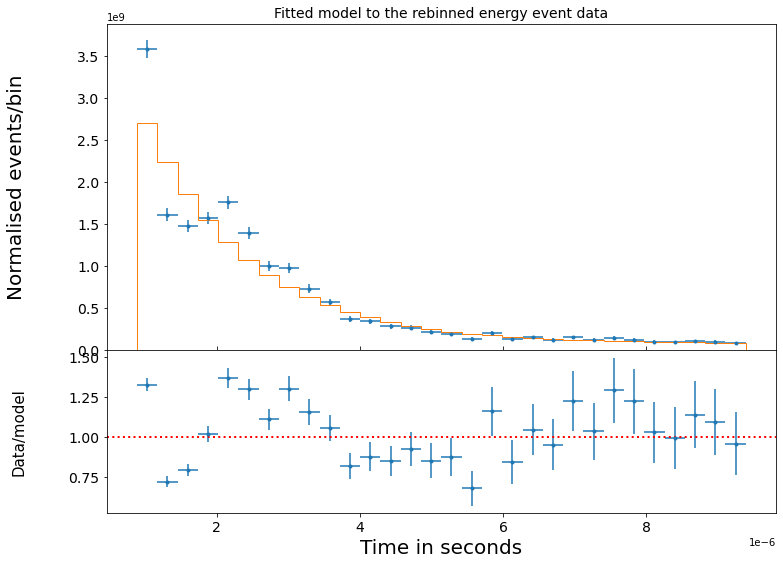

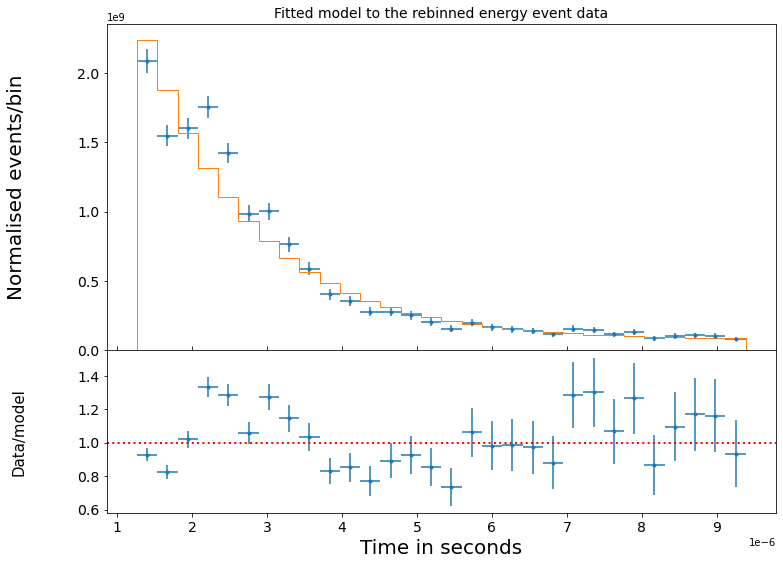

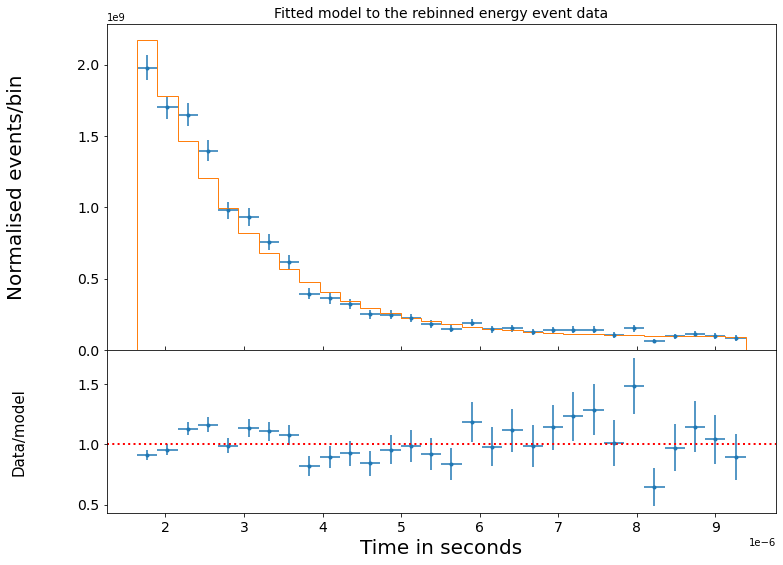

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,9),sharex=True,gridspec_kw={'height_ratios':[2,1]})
fig.subplots_adjust(hspace=0)

for i in range(5):
    distance_list, energy_electron = find_peaks_data(ond_cutoff_list, bov_cutoff_list, counter, 30*i+270, plot = False)
    lifetime, error_lifetime, ebins,cdens,cdens_err,cdens_model = fit_gaussian_to_dataset(np.array(distance_list)* 12.5 * 10**(-9), 30, plot=True)

    color_list = ['blue', 'green', 'red', 'black', 'orange']

    energies = (ebins[1:]+ebins[:-1])/2
    bwidths = np.diff(ebins)
  
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='.', color=color_list[i], alpha = 0.5)
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights = cdens_model, density= False, histtype='step',color=color_list[i], label='Cutoff:' +  str(20*i+270) + '   Fit:'+ str(np.round(lifetime,3)) + ' +/- ' + str(np.round(error_lifetime,3)) + ' Microseconds', linewidth = 2)
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='.',color=color_list[i])

    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
ax1.tick_params(labelsize=14)
ax2.set_xlabel('Time in seconds', fontsize = 20)
ax1.tick_params(axis="x",direction="in",which="both", length=4)
ax2.tick_params(axis="x",which="both", length=4)
ax1.set_ylabel('Normalised events/bin', fontsize = 20)
ax2.set_ylabel('Data/model', fontsize = 15)
ax2.tick_params(labelsize=14)
ax1.get_yaxis().set_label_coords(-0.12,0.5)
ax2.get_yaxis().set_label_coords(-0.12,0.5)
#     ax2.set_xlim(ebins[0],ebins[-1]) # Strictly speaking we should only show the energy range 
# where data is sampled, to avoid impression from model that the flux suddenly drops 
# ax1.set_title('Fitted model to the rebinned energy event data', fontsize = 14)
ax1.legend(prop={'size':15})
plt.savefig('cutoff_fit_lifetime.pdf')
# at the boundaries.
plt.show()
